# Apply AI Superresolution to video - Train VDSR from Video Frames

## Use a perception loss
https://github.com/richzhang/PerceptualSimilarity

 

# Get a video dataset to do better training
- higher resolution than used in research

### super 8 look https://www.youtube.com/watch?v=7Q5UZmwxIXo
- low focus (diffusion and blur - bokah)
- low contrast
- camera is more shakey on home movies
- high depth of field everything is sharp
- 4x3
- film grain
- color changes
- mpeg2 compression noise

### VCR look
- jitter on scan lines - see http://www.avisynth.nl/users/vcmohan/DeJitter/DeJitter.htm
- chroma issues https://forum.videohelp.com/threads/397928-Imrpove-old-video-recorded-by-a-bad-camera?s=0a1230911434e7442d05b6b6cee8e6d2

- jpeg compression artifacts

## use images of related material to train superres
- family photos to train for family videos
- need water and outdoors
- use video samples for video
- use film examples for super8

## Data Augmentation
- sample a few frames from a few places - complete
- different blur levels- complete
- different blur levels in the same image - complete
- convolution with disk - complete
- left-right flip - complete
- contrast and brightness - complete
- random crop - use center crop
- crop to the super8 resolution 720x480 or video 320x240 - complete
- GAN statistics
- predict level of blur with same network to encourage differentiation to that
- input of a filter that detects light reflections to help infer blurring
- try mixup
- use a single shot classifier output as an input

- see this library for blending images https://pypi.org/project/blend-modes/


## Optimization
- Use Adam - complete
- Use optimal learning rate
- freeze layers
- dropout
- use fp16 - pytorch1.6 has a new library for this - complete
- train on low res and increase resolution - does not seem to help in convergence

## losses
- try l1 loss - does not converge
- try perceptive loss vgg18 - complete
- perceptive loss uses 256x256 images - too low res, so use overlapping subsets of image to calc loss
- combine perceptive and mse loss
- calculate mse loss on a smoothed version of output compared to input (which is smoothed) - ensure reversal matches


## do comparisons for standard test sets
- not super useful since they use gaussian blurring, bicubic interpolation
- get very focused images and use as a validation and test set - prefer one thats published


## Results & Analysis
- Fixes - jpeg artifacts were fixed at one level 30 and slope at 0.01 in:
Superresolution train vdsr with multifuz
Superresolution train vdsr with perception loss multifuz

- mse only goes so far.  too strict
- Perceptual loss helps improve it, but input is 256x256 resolution so limited sharpness.
- Perceptual loss tiled (hires) causes too much causes artifacts
- multifuz improves results especially with perceptual loss, handles different fuzziness better

Next experiment
- training may not need to go as long
- set kernel range from 1 to 20 - vs 4-20 need lower range too
- combination of hi res perceptual and mse on smoothed versions of input.

Other ideas
- train on cleaner images div8K
- cascade 2 models.  Train first as usual.  Use it to preprocess input to train second model
- apply mix-up


## Share results
- put out an example on youtube to allow comparison



# Project Documentation

In [1]:

project_base = "/media/SSD/superres/"
results_folder = "Results"
training_folder = "video_data"
model_folder = "checkpoint"


## Experiment documentation

In [2]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [3]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /SSD_link/superres/Superresolution train vdsr with hres perception loss multifuz.ipynb


In [4]:
# Tie a result to a set of params.  Tie a set of params to a model.  Tie a model to a notebook.
# register the experiment to get a unique run id
# save all the results in a repository
# use github to do it?

In [5]:

#%reload_ext autoreload
#%autoreload 2
#%matplotlib inline


import cv2 
import os
import numpy as np
import subprocess as sp
import time
from tqdm import tqdm, trange
from pathlib import Path
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.transforms import RandomHorizontalFlip,ColorJitter
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize, Grayscale

import random
from astropy.convolution import  Gaussian2DKernel, Tophat2DKernel,AiryDisk2DKernel


import sys
sys.path.insert(0, '/media/SSD/superres/pytorch-vdsr/')

#from vdsr import Net

import lpips #https://github.com/richzhang/PerceptualSimilarity

In [6]:
import torch.utils.data as data

from os import listdir
from os.path import join
from PIL import Image, ImageFilter
import numpy as np
import torchvision as vision

import numbers


torch.cuda.manual_seed(42)

Create a data loader
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data.py
- see https://github.com/2KangHo/vdsr_pytorch/blob/master/data_utils.py

In [7]:



toPIL = vision.transforms.ToPILImage()


def noisy(img, std=3.0):
    mean = 0.0
    gauss = np.random.normal(mean, std, (img.height, img.width, 3))
    # noisy = np.clip(np.uint8(img + gauss), 0, 255)
    noisy = np.uint8(img + gauss)
    return noisy


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])



In [8]:
def is_video_file(path, extensions = ("mp4",)):
    return path.lower().endswith(extensions)

def frame_sampler1(length, frame_sample_size):

    # calculate middle of video and take 'frame_sample_size' frames from middle
    middle = length // 2
    left_length = frame_sample_size//2
    right_length = frame_sample_size - left_length
    left = max(0,middle - left_length)
    right = min(length, middle + right_length)
          
    return list(range(left,right))



def frame_sampler2(length, frame_sample_size):
    return np.linspace(0, length, 3+min(frame_sample_size,length)).astype(int)[2:-1]


# Make this load still photos too, and have them added with frame = 0
def make_framelist(video_dir,frame_sample_size = 10):
    instances = []
    for filename in listdir(video_dir):
        filepath = os.path.join(video_dir,filename)
        #print(filename)
        
        if is_video_file(filepath):
            # open video file
            cap = cv2.VideoCapture(str(filepath))

            # get frame count
            length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            cap.release()
            
            if frame_sample_size is not None:
                samples = frame_sampler2(length, frame_sample_size)
                # append fn and frame num to instances
            else:
                samples = range(0,length)
                
            for frame in samples:
                item = {"Filepath":filepath,"Type":"frame",  "Framenum":frame}
                instances.append(item)
                
        elif is_image_file(filepath):
            # open image file
            img = cv2.imread(filepath)
            item = {"Filepath":filepath, "Type":"image"}
            instances.append(item)
            
    return instances
        

In [9]:
# get a list of all the data
instances = make_framelist("/media/SSD/superres/video_data",1)

In [10]:
instances

[{'Filepath': '/media/SSD/superres/video_data/101890319.mp4',
  'Type': 'frame',
  'Framenum': 3431},
 {'Filepath': '/media/SSD/superres/video_data/107132164.mp4',
  'Type': 'frame',
  'Framenum': 1634},
 {'Filepath': '/media/SSD/superres/video_data/104453980.mp4',
  'Type': 'frame',
  'Framenum': 15060},
 {'Filepath': '/media/SSD/superres/video_data/103604430.mp4',
  'Type': 'frame',
  'Framenum': 5538},
 {'Filepath': '/media/SSD/superres/video_data/110371795.mp4',
  'Type': 'frame',
  'Framenum': 744},
 {'Filepath': '/media/SSD/superres/video_data/101224055.mp4',
  'Type': 'frame',
  'Framenum': 3954},
 {'Filepath': '/media/SSD/superres/video_data/101094248.mp4',
  'Type': 'frame',
  'Framenum': 3290},
 {'Filepath': '/media/SSD/superres/video_data/106501635.mp4',
  'Type': 'frame',
  'Framenum': 1580},
 {'Filepath': '/media/SSD/superres/video_data/102797996.mp4',
  'Type': 'frame',
  'Framenum': 542},
 {'Filepath': '/media/SSD/superres/video_data/114651311.mp4',
  'Type': 'frame',
  

In [11]:
def load_frame(instance):
    
    path = instance["Filepath"]
    
    if instance["Type"] == "frame":
        
        frame = instance["Framenum"]
        cap = cv2.VideoCapture(path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame-1)
        ret, img = cap.read()
        if ret==0:
            print("Error with:",instance)
    elif instance["Type"] == "image":
        img = cv2.imread(path)
    # convert to PIL RGB
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return Image.fromarray(im_rgb)



In [12]:


class RescaleCrop(object):


    def __init__(self, crop_size ,kernel_width):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_width = kernel_width
        

    
        

    def __call__(self, img):
        
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+self.kernel_width+1)
        h_wanted = int(self.crop_size[1]+self.kernel_width+1)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img = CenterCrop((v_wanted,h_wanted))(img) 

        
        return img

In [13]:


class DatasetFromVideoFolder(data.Dataset):
    def __init__(self, video_dir,size,frame_sample_size=None, input_transform=None, target_transform=None, add_noise=None, noise_std=3.0, Flip_hor=False,Rand_bright_contrast=False, kernel_width=10):
        super(DatasetFromVideoFolder, self).__init__()
        self.video_frames = make_framelist(video_dir,frame_sample_size)

        self.input_transform = input_transform
        self.target_transform = target_transform
        self.add_noise = add_noise
        self.noise_std = noise_std
        self.Flip_hor = Flip_hor
        self.Rand_bright_contrast = Rand_bright_contrast
        self.size = size
        self.kernel_width = kernel_width

    def __getitem__(self, index):
        input = load_frame(self.video_frames[index])
        
        input = RescaleCrop(self.size,self.kernel_width )(input)
        
        if self.Flip_hor:
            input = RandomHorizontalFlip()(input)
        
        if self.Rand_bright_contrast:
            input = ColorJitter(brightness=.2, contrast=.2)(input)
        
        
        target = input.copy()
        if self.input_transform:
            if self.add_noise:
                input = noisy(input, self.noise_std)
                input = toPIL(input)
            input = self.input_transform(input)
        if self.target_transform:
            target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.video_frames)

In [14]:

def cv_center_crop(img,output_size):
        if isinstance(output_size, numbers.Number):
            output_size = (int(output_size), int(output_size))
            
        
        image_height = img.shape[0]
        image_width = img.shape[1]
        
        crop_height, crop_width = output_size
        crop_top = max(0,int(round((image_height - crop_height) / 2.)))
        crop_left = max(0,int(round((image_width - crop_width) / 2.)))
        #print("input:",img.shape)
        #print("output:",output_size)
        #print("crop:",crop_top,crop_top+output_size[0],crop_left,crop_left+output_size[1])
        return img[crop_top:crop_top+output_size[0],crop_left:crop_left+output_size[1]]

In [15]:


class CropRescale(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        #print("size of image",img.size)
        
        # Ideal steps
        # Crop with proportional scale, to simulate images of different input resolutions (if thats a requirement)
        # This crop should leave some edges of the image to allow blurring with kernel beyond final size
        # Blur the image 
        # If different randomly picked blurring kernels are used, they should have equivalent blurring power.
        
        h_size,v_size = img.size
        
        #print("im size:", img.size)
        
        # Resize down to a size a bit larger than final size to allow proper blurring
        v_wanted = int(self.crop_size[0]+2*rand_scale_factor+2)
        h_wanted = int(self.crop_size[1]+2*rand_scale_factor+2)
        
        #print("im wanted:", (h_wanted, v_wanted))
        
        h_scale = h_wanted/h_size
        v_scale = v_wanted/v_size
        
        scale = max(h_scale, v_scale)
        
        #print("scales=",(h_scale, v_scale))
        
        #print("new size=",(int(h_size*scale), int(v_size*scale)))
        img = img.resize((int(h_size*scale), int(v_size*scale)))
        
        img_cv = cv_center_crop(np.array(img),(v_wanted,h_wanted))  

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        img_cv = cv2.filter2D(img_cv, -1, Tophat2DKernel(rand_scale_factor).array)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        #rand_quality_factor = random.uniform(30,90)
        #is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        #img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [16]:
class Crappify(object):


    def __init__(self, crop_size ,factor_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.factor_range = factor_range
        

    
        

    def __call__(self, img):
        
        rand_scale_factor = random.uniform(*self.factor_range)
        
        img_cv = np.array(img)

        
        #Disk Blur
        #print(max(np.array(img)), min(np.array(img)))
        k = Tophat2DKernel(int(rand_scale_factor)/2.0).array
        k = k/k.sum()
        
        
        img_cv = cv2.filter2D(img_cv, -1, k)
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        rand_quality_factor = random.uniform(30,90)
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,30])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

In [17]:
def create_circular_mask(h, w, slope=0.01, center=None, radius=None, scale=1.0):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((scale*(X - center[0]))**2 + ((Y-center[1])/scale)**2)

    mask = np.minimum((np.maximum(dist_from_center-radius,0)*slope)**(0.5),1.0)
    return mask

In [76]:
class Multifuz(object):


    def __init__(self, crop_size ,kernel_range, quality_range, slope_range, radius_range, scale_range):
        
        if isinstance(crop_size, numbers.Number):
            self.crop_size = (int(crop_size), int(crop_size))
        else:
            self.crop_size = crop_size 
        
        self.kernel_range = kernel_range
        self.quality_range = quality_range
        self.slope_range = slope_range
        self.radius_range = radius_range
        self.scale_range = scale_range
        

    
        

    def __call__(self, img):
        
        img_cv = np.array(img)
        d = img_cv .shape
        dim = (d[1], d[0])
        height = d[0]
        width = d[1]
        color = len(d)-2
        
        rand_kernel = random.uniform(*self.kernel_range)
        rand_quality = random.uniform(*self.quality_range)
        rand_slope = random.uniform(*self.slope_range)
        rand_radius = random.uniform(*self.radius_range)*max(self.crop_size[0],self.crop_size[1])
        
        crop_top = max(0,int(round((height - self.crop_size[0]) / 2.)))
        crop_bottom = crop_top + self.crop_size[0]
        crop_left = max(0,int(round((width - self.crop_size[1]) / 2.)))
        crop_right = crop_left + self.crop_size[1]
        
        rand_center = (random.uniform(crop_left, crop_right),random.uniform(crop_top, crop_bottom))
        
        rand_scale = random.uniform(0.5,2)
        #technically should adjust the scale to the crop size scale of the final image
        
        #blur kernel A
        
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurA = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        #blur kernel B
        rand_kernel = random.uniform(*self.kernel_range)
        k = Tophat2DKernel(int(rand_kernel)/2.0).array
        k = k/k.sum()
        img_cv_blurB = cv2.filter2D(img_cv, cv2.CV_32F, k)
        
        
        #add them with a mask
        # Normalize the alpha mask to keep intensity between 0 and 1
        
        alpha = create_circular_mask(h=height, w=width, slope=rand_slope,center=rand_center, radius=rand_radius, scale = rand_scale)*1.0
        
        if color ==1:
            alpha=np.reshape(alpha, (height,width,-1))
            alpha=np.broadcast_to(alpha,[height,width,3])
        
        #alpha = alpha.astype(float)/255
        
        # Multiply the foreground with the alpha matte
        
        img_cv_blurA = cv2.multiply(img_cv_blurA, alpha, dtype=cv2.CV_32F )
        # Multiply the background with ( 1 - alpha )

        
        img_cv_blurB = cv2.multiply(img_cv_blurB, 1.0 - alpha, dtype=cv2.CV_32F)
        # Add the masked foreground and background.

        #img_cv = img_cv_blurA
        img_cv = cv2.add(img_cv_blurA, img_cv_blurB, dtype=cv2.CV_32F)
        
        img_cv = cv2.normalize(img_cv, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
        
        
        
    
        #Center Crop
        img_cv = cv_center_crop(img_cv,self.crop_size)
        
        #Jpeg compression (for adding artifacts)
        
        is_success, im_buf_arr = cv2.imencode(".jpg", img_cv,params = [cv2.IMWRITE_JPEG_QUALITY,rand_quality])
        img_cv = cv2.imdecode(im_buf_arr,flags=cv2.IMREAD_COLOR)
        
        
        img= Image.fromarray(img_cv)
        return img

(1280, 720) (720, 480)


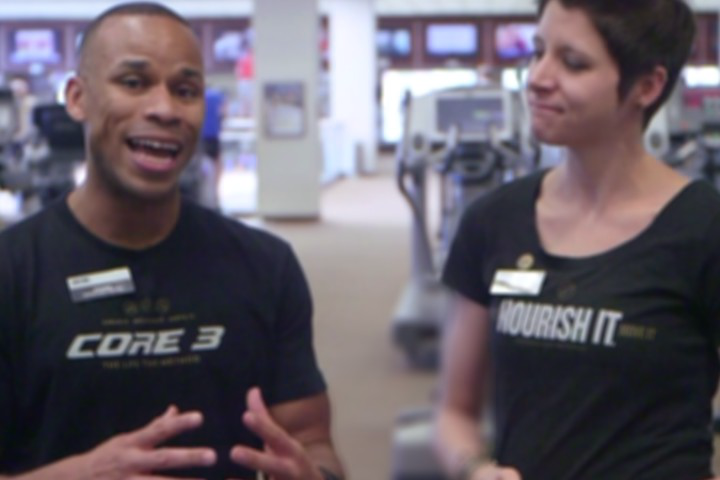

In [93]:
#test the CropRescale transform
im=load_frame(instances[10])
#im = Grayscale(num_output_channels=1)(im)
#im_res = RescaleCrop(crop_size = (480,720), kernel_width=1)(im)
im_res = Multifuz(crop_size = (480,720),
                  kernel_range=(1,16), 
                  quality_range=(90,90), 
                  slope_range=(0.0001, 0.1),
                 radius_range=(.05,.5),
                 scale_range=(1/2,2))(im)
print(im.size,im_res.size)
type(im_res)
im_res

In [94]:


def input_transform(crop_size, kernel_range):
    
    
    return Compose([
        
        Multifuz(crop_size = crop_size,
                  kernel_range=kernel_range, 
                  quality_range=(30,90), 
                  slope_range=(0.00001, 0.01),
                 radius_range=(.05,.75),
                 scale_range=(1/2,2)), 
        Grayscale(num_output_channels=1),
        ToTensor(),
    ])



def target_transform(crop_size):
    print(crop_size)
    return Compose([
        Grayscale(num_output_channels=1),
        CenterCrop(crop_size),
        ToTensor(),
    ])


def get_training_set(data_dir, crop_size, kernel_range, frame_sample_size=10, add_noise=None, 
                     noise_std=3.0,Flip_hor=True,Rand_bright_contrast=True):
    

    cropsize = crop_size
    return DatasetFromVideoFolder(data_dir,crop_size, frame_sample_size,
                             input_transform=input_transform(
                                 crop_size, kernel_range),
                             target_transform=target_transform(crop_size),
                             add_noise=add_noise,
                             noise_std=noise_std,Flip_hor=Flip_hor,
                             Rand_bright_contrast=Rand_bright_contrast)


## Below functions need work

def get_validation_set(data_dir, crop_size, kernel_range):
    
    
    return DatasetFromVideoFolder(data_dir,frame_sample_size,
                             input_transform=input_transform(
                                 cropsize, kernel_range,frame_sample_size=10),
                             target_transform=target_transform(cropsize))


def get_test_set(data_dir, crop_size, upscale_factor):


    return DatasetFromVideoFolder(data_dir,frame_sample_size=None,
                             input_transform=input_transform(
                                 cropsize, upscale_factor),
                             target_transform=target_transform(cropsize))

In [95]:
train_dir = "/media/SSD/superres/video_data"
frame_sample_size =10
batch_size = 4 # Make 4 For FP16, 480x720 size images
crop_size = (480,720)
kernel_range=(4,20)
add_noise=False
noise_std=3.0
Flip_hor=True
Rand_bright_contrast=True

In [96]:
# create a data set
# split it using random split
# random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))


In [97]:
train_set = get_training_set(data_dir=train_dir, crop_size=crop_size,
            kernel_range=kernel_range,frame_sample_size =frame_sample_size, 
            add_noise=add_noise, noise_std=noise_std,Flip_hor=Flip_hor,Rand_bright_contrast=Rand_bright_contrast)
training_data_loader = DataLoader(dataset=train_set, num_workers=0, batch_size=batch_size, shuffle=True)

(480, 720)


In [98]:
# measurement of blur of an image
def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

In [99]:

def show_batch(dataloader,size = 8):

    inputs, outputs = next(iter(dataloader))
    print(inputs.shape)
    inputs = inputs.numpy().transpose((0, 2, 3, 1))
    outputs = outputs.numpy().transpose((0, 2, 3, 1))
    
    
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inputs = inputs*std + mean
    #outputs = outputs*std + mean
    w,h = 2*size, 4*size
    fig=plt.figure(figsize=(w, h))
    columns = 2
    rows = 4
    ax=[]
    
    for i in range(0, rows):
        blur_measure_input = variance_of_laplacian((inputs[i]*255).astype(np.uint8))
        blur_measure_output = variance_of_laplacian((outputs[i]*255).astype(np.uint8))
        ax.append(fig.add_subplot(rows, columns, 2*i+1))
        ax[-1].set_title('Blur: '+str(blur_measure_input))
        plt.imshow((inputs[i]*255).astype(np.uint8),cmap='gray')
        ax.append(fig.add_subplot(rows, columns, 2*i+2))
        ax[-1].set_title('Blur: '+str(blur_measure_output))
        plt.imshow((outputs[i]*255).astype(np.uint8),cmap='gray')
    plt.show()

torch.Size([4, 1, 480, 720])


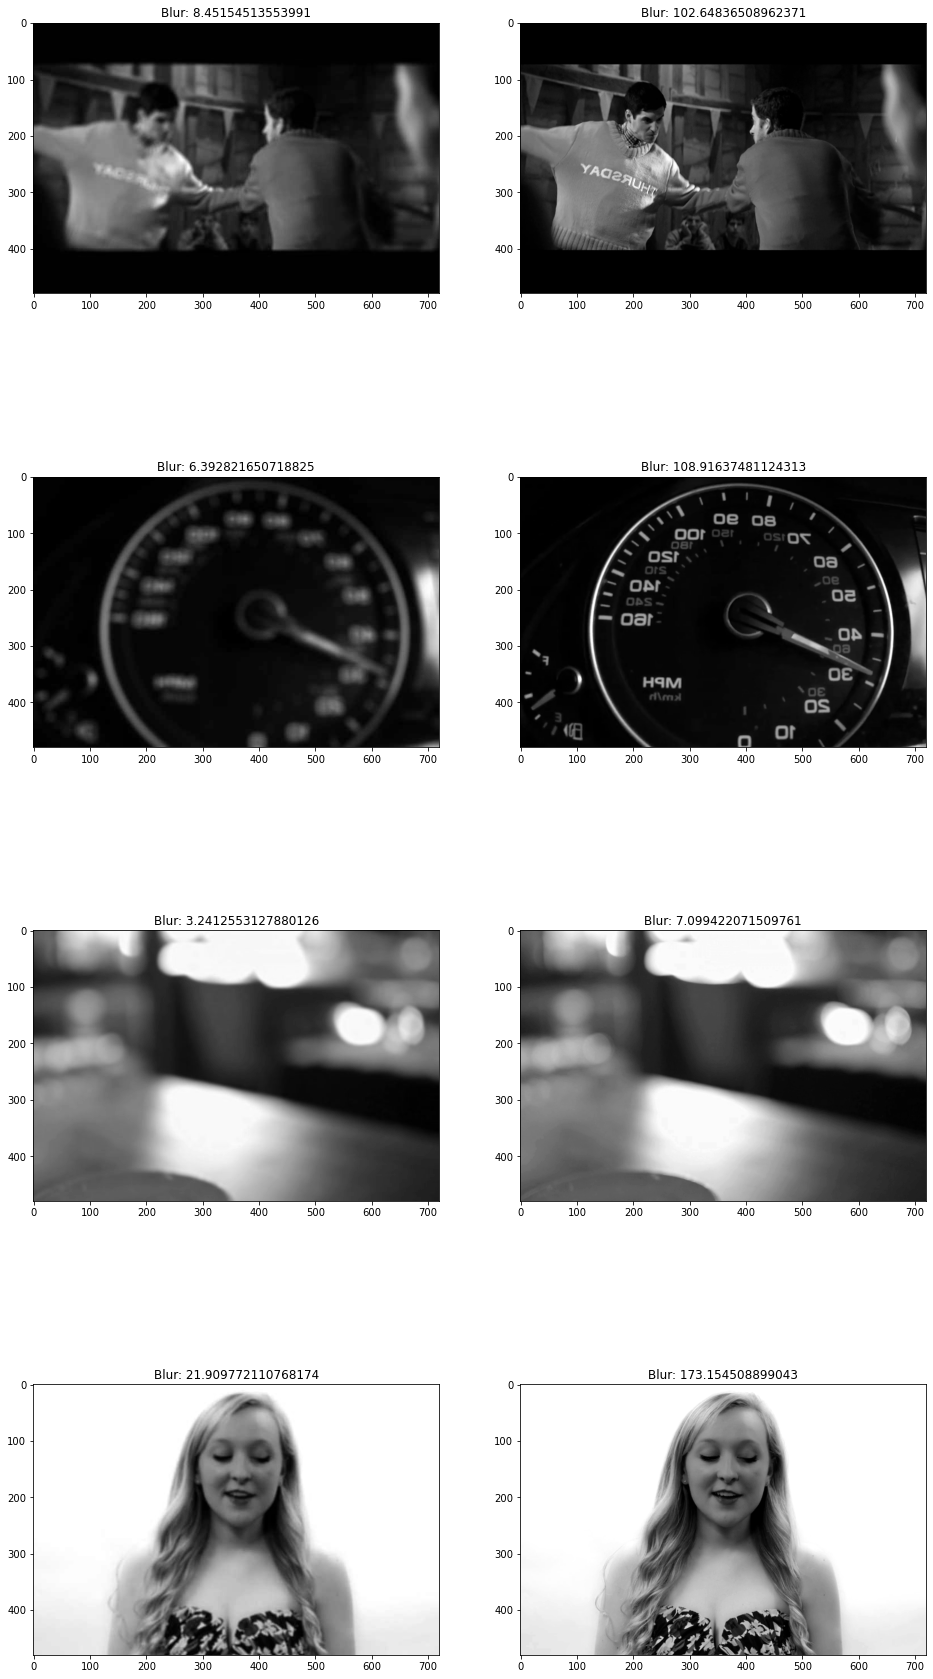

In [101]:
show_batch(training_data_loader,size =8)

# VDSR with dropout

In [ ]:
import torch.nn as nn
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self):
        super(Conv_ReLU_Block, self).__init__()
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.do = nn.Dropout2d(p=0.5, inplace=True)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, 18)
        self.input = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        for _ in range(num_of_layer):
            layers.append(block())
        return nn.Sequential(*layers)

    def forward(self, x):
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

# Build the model

In [ ]:
model = Net()
model.cuda()


In [161]:
model = torch.load("/media/SSD/superres/pytorch-vdsr/model/model_epoch_50.pth")["model"]



/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/media/SSD/conda_env/superres/lib/python3.8/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original sourc

In [ ]:
model

In [103]:
#criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

#loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
#loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

loss_fn = lpips.LPIPS(net='alex')
loss_fn.cuda()

def loss_scaler(im):
    # scale to -1,1 and convert to 3 channel (greyscale to RBG)
    return (im * 2 - 1).expand(-1, 3, -1, -1)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /media/SSD/conda_env/superres/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [104]:
class P_Loss(torch.nn.Module):
    
    def __init__(self):
        super(P_Loss,self).__init__()
        
    def forward(self,x,y):
        
        totloss = torch.mean(loss_fn.forward(loss_scaler(x),loss_scaler(y)))
        
        # approach to split image into blocks since loss works on 256x256 images
        for i in [0, 224]:
            for j in [0, 232, 464 ]:
                x_crop = x[:,:,i:i+255, j:j+255]
                y_crop = y[:,:,i:i+255, j:j+255]
                totloss.add_(torch.mean(loss_fn.forward(loss_scaler(x_crop),loss_scaler(y_crop))))
            
        #do we need to work in color?
        
        return totloss

In [ ]:
list(range(0,1280-256,256-int((256*6-1280)/5)))

In [ ]:
list(range(0,720-256,256-int((256*3-720)/2)))

In [105]:
criterion = P_Loss()

#criterion.cuda()

In [106]:
init_lr = 0.1/100
lr_step = 3
gradient_clip = 0.4
epochs = 27

In [107]:
#optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=init_lr, weight_decay=1e-4)

In [108]:
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=0.01,
                                          steps_per_epoch=len(training_data_loader),
                                          epochs=epochs)

In [109]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10**0.5 every 3 epochs"""
    lr = init_lr * (0.1 ** (.5*(epoch // lr_step)))
    return lr

In [110]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "hresperfuzmodel1_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [111]:
import datetime
from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [112]:
def trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler):
    dt = str(datetime.datetime.now())
    print("Start Time:", dt)
    
    lr = adjust_learning_rate(optimizer, epoch-1)

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))

    model.train()
    cum_loss2=0
    cum_loss = 0
    ct=0
    ct2=0

    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

        
        input = input.cuda()
        target = target.cuda()
        
        # Runs the forward pass with autocasting.
        with autocast():
            loss = criterion(model(input), target)
            
        
        optimizer.zero_grad()
        
        scaler.scale(loss).backward()
        #loss.backward() 
        
        # Unscales the gradients of optimizer's assigned params in-place
        scaler.unscale_(optimizer)
        
        nn.utils.clip_grad_norm_(model.parameters(),gradient_clip) 
        
        #optimizer.step()
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        #scheduler.step()
        
        cum_loss = cum_loss + loss.data
        cum_loss2 = cum_loss2 + loss.data
        ct2=ct2+batch_size
        ct = ct +batch_size
        

        if iteration%10 == 0:
            dt = str(datetime.datetime.now())
            print("===> Time: {} Epoch[{}]({}/{}): LR: {} : Loss: {:.10f}".format(dt,epoch, iteration, len(training_data_loader), optimizer.param_groups[0]["lr"], cum_loss/ct))
            ct=0
            cum_loss =0
    print("Epoch Loss:", cum_loss2/ct2)        

In [113]:
# Creates a GradScaler once at the beginning of training for mixed precision
scaler = GradScaler()


for epoch in range(1, epochs+1):
        trainfp16(training_data_loader, optimizer, scheduler, model, criterion, epoch,scaler)
        save_checkpoint(model, epoch)

Start Time: 2020-09-24 15:47:57.819220
Epoch = 1, lr = 0.001
===> Time: 2020-09-24 15:48:10.572401 Epoch[1](10/1586): LR: 0.001 : Loss: 0.8320312500
===> Time: 2020-09-24 15:48:22.900041 Epoch[1](20/1586): LR: 0.001 : Loss: 0.4833984375
===> Time: 2020-09-24 15:48:35.173618 Epoch[1](30/1586): LR: 0.001 : Loss: 0.3784179688
===> Time: 2020-09-24 15:48:47.572329 Epoch[1](40/1586): LR: 0.001 : Loss: 0.4858398438
===> Time: 2020-09-24 15:48:59.838526 Epoch[1](50/1586): LR: 0.001 : Loss: 0.4135742188
===> Time: 2020-09-24 15:49:12.661654 Epoch[1](60/1586): LR: 0.001 : Loss: 0.4499511719
===> Time: 2020-09-24 15:49:25.326009 Epoch[1](70/1586): LR: 0.001 : Loss: 0.4729003906
===> Time: 2020-09-24 15:49:37.773333 Epoch[1](80/1586): LR: 0.001 : Loss: 0.4506835938
===> Time: 2020-09-24 15:49:50.491121 Epoch[1](90/1586): LR: 0.001 : Loss: 0.3891601562
===> Time: 2020-09-24 15:50:03.240357 Epoch[1](100/1586): LR: 0.001 : Loss: 0.4565429688
===> Time: 2020-09-24 15:50:15.787831 Epoch[1](110/1586): 

===> Time: 2020-09-24 16:07:09.325487 Epoch[1](930/1586): LR: 0.001 : Loss: 0.4179687500
===> Time: 2020-09-24 16:07:21.588802 Epoch[1](940/1586): LR: 0.001 : Loss: 0.3781738281
===> Time: 2020-09-24 16:07:33.975690 Epoch[1](950/1586): LR: 0.001 : Loss: 0.3984375000
===> Time: 2020-09-24 16:07:46.248869 Epoch[1](960/1586): LR: 0.001 : Loss: 0.3740234375
===> Time: 2020-09-24 16:07:58.713571 Epoch[1](970/1586): LR: 0.001 : Loss: 0.3554687500
===> Time: 2020-09-24 16:08:10.768902 Epoch[1](980/1586): LR: 0.001 : Loss: 0.3281250000
===> Time: 2020-09-24 16:08:22.918413 Epoch[1](990/1586): LR: 0.001 : Loss: 0.4013671875
===> Time: 2020-09-24 16:08:35.407469 Epoch[1](1000/1586): LR: 0.001 : Loss: 0.4069824219
===> Time: 2020-09-24 16:08:47.762089 Epoch[1](1010/1586): LR: 0.001 : Loss: 0.3791503906
===> Time: 2020-09-24 16:09:00.085286 Epoch[1](1020/1586): LR: 0.001 : Loss: 0.4160156250
===> Time: 2020-09-24 16:09:12.374328 Epoch[1](1030/1586): LR: 0.001 : Loss: 0.3383789062
===> Time: 2020-0

===> Time: 2020-09-24 16:25:33.325300 Epoch[2](250/1586): LR: 0.001 : Loss: 0.3366699219
===> Time: 2020-09-24 16:25:45.407137 Epoch[2](260/1586): LR: 0.001 : Loss: 0.4084472656
===> Time: 2020-09-24 16:25:57.419530 Epoch[2](270/1586): LR: 0.001 : Loss: 0.3435058594
===> Time: 2020-09-24 16:26:09.664872 Epoch[2](280/1586): LR: 0.001 : Loss: 0.3603515625
===> Time: 2020-09-24 16:26:21.940349 Epoch[2](290/1586): LR: 0.001 : Loss: 0.3903808594
===> Time: 2020-09-24 16:26:34.221063 Epoch[2](300/1586): LR: 0.001 : Loss: 0.3691406250
===> Time: 2020-09-24 16:26:46.215812 Epoch[2](310/1586): LR: 0.001 : Loss: 0.3554687500
===> Time: 2020-09-24 16:26:58.247142 Epoch[2](320/1586): LR: 0.001 : Loss: 0.3437500000
===> Time: 2020-09-24 16:27:10.375307 Epoch[2](330/1586): LR: 0.001 : Loss: 0.3637695312
===> Time: 2020-09-24 16:27:22.553799 Epoch[2](340/1586): LR: 0.001 : Loss: 0.3359375000
===> Time: 2020-09-24 16:27:34.559774 Epoch[2](350/1586): LR: 0.001 : Loss: 0.3806152344
===> Time: 2020-09-24

===> Time: 2020-09-24 16:44:12.195918 Epoch[2](1170/1586): LR: 0.001 : Loss: 0.3281250000
===> Time: 2020-09-24 16:44:24.491729 Epoch[2](1180/1586): LR: 0.001 : Loss: 0.3181152344
===> Time: 2020-09-24 16:44:36.481071 Epoch[2](1190/1586): LR: 0.001 : Loss: 0.3986816406
===> Time: 2020-09-24 16:44:48.652820 Epoch[2](1200/1586): LR: 0.001 : Loss: 0.3459472656
===> Time: 2020-09-24 16:45:00.901686 Epoch[2](1210/1586): LR: 0.001 : Loss: 0.3818359375
===> Time: 2020-09-24 16:45:13.036093 Epoch[2](1220/1586): LR: 0.001 : Loss: 0.3398437500
===> Time: 2020-09-24 16:45:25.135276 Epoch[2](1230/1586): LR: 0.001 : Loss: 0.3344726562
===> Time: 2020-09-24 16:45:37.318654 Epoch[2](1240/1586): LR: 0.001 : Loss: 0.3371582031
===> Time: 2020-09-24 16:45:49.509241 Epoch[2](1250/1586): LR: 0.001 : Loss: 0.3745117188
===> Time: 2020-09-24 16:46:01.630679 Epoch[2](1260/1586): LR: 0.001 : Loss: 0.3281250000
===> Time: 2020-09-24 16:46:13.677696 Epoch[2](1270/1586): LR: 0.001 : Loss: 0.3398437500
===> Time:

===> Time: 2020-09-24 17:02:26.464513 Epoch[3](490/1586): LR: 0.001 : Loss: 0.3093261719
===> Time: 2020-09-24 17:02:38.406648 Epoch[3](500/1586): LR: 0.001 : Loss: 0.3398437500
===> Time: 2020-09-24 17:02:50.346324 Epoch[3](510/1586): LR: 0.001 : Loss: 0.3066406250
===> Time: 2020-09-24 17:03:02.396093 Epoch[3](520/1586): LR: 0.001 : Loss: 0.2971191406
===> Time: 2020-09-24 17:03:14.190170 Epoch[3](530/1586): LR: 0.001 : Loss: 0.2858886719
===> Time: 2020-09-24 17:03:26.148810 Epoch[3](540/1586): LR: 0.001 : Loss: 0.3330078125
===> Time: 2020-09-24 17:03:37.965750 Epoch[3](550/1586): LR: 0.001 : Loss: 0.3784179688
===> Time: 2020-09-24 17:03:49.985977 Epoch[3](560/1586): LR: 0.001 : Loss: 0.3269042969
===> Time: 2020-09-24 17:04:01.782314 Epoch[3](570/1586): LR: 0.001 : Loss: 0.3867187500
===> Time: 2020-09-24 17:04:13.738300 Epoch[3](580/1586): LR: 0.001 : Loss: 0.3310546875
===> Time: 2020-09-24 17:04:25.627525 Epoch[3](590/1586): LR: 0.001 : Loss: 0.3522949219
===> Time: 2020-09-24

===> Time: 2020-09-24 17:20:55.220429 Epoch[3](1410/1586): LR: 0.001 : Loss: 0.3166503906
===> Time: 2020-09-24 17:21:07.243373 Epoch[3](1420/1586): LR: 0.001 : Loss: 0.3291015625
===> Time: 2020-09-24 17:21:19.240133 Epoch[3](1430/1586): LR: 0.001 : Loss: 0.3139648438
===> Time: 2020-09-24 17:21:31.423338 Epoch[3](1440/1586): LR: 0.001 : Loss: 0.3339843750
===> Time: 2020-09-24 17:21:43.648634 Epoch[3](1450/1586): LR: 0.001 : Loss: 0.3376464844
===> Time: 2020-09-24 17:21:55.917795 Epoch[3](1460/1586): LR: 0.001 : Loss: 0.3642578125
===> Time: 2020-09-24 17:22:07.863704 Epoch[3](1470/1586): LR: 0.001 : Loss: 0.3154296875
===> Time: 2020-09-24 17:22:19.781038 Epoch[3](1480/1586): LR: 0.001 : Loss: 0.3037109375
===> Time: 2020-09-24 17:22:31.903377 Epoch[3](1490/1586): LR: 0.001 : Loss: 0.3654785156
===> Time: 2020-09-24 17:22:43.744710 Epoch[3](1500/1586): LR: 0.001 : Loss: 0.3679199219
===> Time: 2020-09-24 17:22:55.752870 Epoch[3](1510/1586): LR: 0.001 : Loss: 0.3017578125
===> Time:

===> Time: 2020-09-24 17:36:56.649950 Epoch[4](620/1586): LR: 0.00031622776601683794 : Loss: 0.3151855469
===> Time: 2020-09-24 17:37:08.736449 Epoch[4](630/1586): LR: 0.00031622776601683794 : Loss: 0.2929687500
===> Time: 2020-09-24 17:37:21.073426 Epoch[4](640/1586): LR: 0.00031622776601683794 : Loss: 0.3212890625
===> Time: 2020-09-24 17:37:33.269883 Epoch[4](650/1586): LR: 0.00031622776601683794 : Loss: 0.3410644531
===> Time: 2020-09-24 17:37:45.427822 Epoch[4](660/1586): LR: 0.00031622776601683794 : Loss: 0.3413085938
===> Time: 2020-09-24 17:37:57.541277 Epoch[4](670/1586): LR: 0.00031622776601683794 : Loss: 0.3024902344
===> Time: 2020-09-24 17:38:09.611707 Epoch[4](680/1586): LR: 0.00031622776601683794 : Loss: 0.2873535156
===> Time: 2020-09-24 17:38:21.896451 Epoch[4](690/1586): LR: 0.00031622776601683794 : Loss: 0.3212890625
===> Time: 2020-09-24 17:38:34.003875 Epoch[4](700/1586): LR: 0.00031622776601683794 : Loss: 0.3291015625
===> Time: 2020-09-24 17:38:46.161658 Epoch[4]

===> Time: 2020-09-24 17:52:31.906619 Epoch[4](1390/1586): LR: 0.00031622776601683794 : Loss: 0.2851562500
===> Time: 2020-09-24 17:52:44.188419 Epoch[4](1400/1586): LR: 0.00031622776601683794 : Loss: 0.2978515625
===> Time: 2020-09-24 17:52:56.285701 Epoch[4](1410/1586): LR: 0.00031622776601683794 : Loss: 0.3017578125
===> Time: 2020-09-24 17:53:08.495963 Epoch[4](1420/1586): LR: 0.00031622776601683794 : Loss: 0.3527832031
===> Time: 2020-09-24 17:53:20.785650 Epoch[4](1430/1586): LR: 0.00031622776601683794 : Loss: 0.3498535156
===> Time: 2020-09-24 17:53:33.067785 Epoch[4](1440/1586): LR: 0.00031622776601683794 : Loss: 0.3000488281
===> Time: 2020-09-24 17:53:44.982253 Epoch[4](1450/1586): LR: 0.00031622776601683794 : Loss: 0.3002929688
===> Time: 2020-09-24 17:53:57.120809 Epoch[4](1460/1586): LR: 0.00031622776601683794 : Loss: 0.3291015625
===> Time: 2020-09-24 17:54:09.333130 Epoch[4](1470/1586): LR: 0.00031622776601683794 : Loss: 0.3344726562
===> Time: 2020-09-24 17:54:21.445437

===> Time: 2020-09-24 18:07:58.830338 Epoch[5](570/1586): LR: 0.00031622776601683794 : Loss: 0.3339843750
===> Time: 2020-09-24 18:08:10.738612 Epoch[5](580/1586): LR: 0.00031622776601683794 : Loss: 0.2883300781
===> Time: 2020-09-24 18:08:22.744228 Epoch[5](590/1586): LR: 0.00031622776601683794 : Loss: 0.3066406250
===> Time: 2020-09-24 18:08:34.363050 Epoch[5](600/1586): LR: 0.00031622776601683794 : Loss: 0.2851562500
===> Time: 2020-09-24 18:08:46.411507 Epoch[5](610/1586): LR: 0.00031622776601683794 : Loss: 0.3317871094
===> Time: 2020-09-24 18:08:58.250353 Epoch[5](620/1586): LR: 0.00031622776601683794 : Loss: 0.3544921875
===> Time: 2020-09-24 18:09:10.627237 Epoch[5](630/1586): LR: 0.00031622776601683794 : Loss: 0.3186035156
===> Time: 2020-09-24 18:09:22.810956 Epoch[5](640/1586): LR: 0.00031622776601683794 : Loss: 0.2968750000
===> Time: 2020-09-24 18:09:34.828569 Epoch[5](650/1586): LR: 0.00031622776601683794 : Loss: 0.3251953125
===> Time: 2020-09-24 18:09:47.032790 Epoch[5]

===> Time: 2020-09-24 18:23:25.596993 Epoch[5](1340/1586): LR: 0.00031622776601683794 : Loss: 0.2939453125
===> Time: 2020-09-24 18:23:37.612428 Epoch[5](1350/1586): LR: 0.00031622776601683794 : Loss: 0.3098144531
===> Time: 2020-09-24 18:23:49.346842 Epoch[5](1360/1586): LR: 0.00031622776601683794 : Loss: 0.3183593750
===> Time: 2020-09-24 18:24:01.542178 Epoch[5](1370/1586): LR: 0.00031622776601683794 : Loss: 0.3613281250
===> Time: 2020-09-24 18:24:13.542259 Epoch[5](1380/1586): LR: 0.00031622776601683794 : Loss: 0.3315429688
===> Time: 2020-09-24 18:24:25.633811 Epoch[5](1390/1586): LR: 0.00031622776601683794 : Loss: 0.3310546875
===> Time: 2020-09-24 18:24:37.652059 Epoch[5](1400/1586): LR: 0.00031622776601683794 : Loss: 0.3310546875
===> Time: 2020-09-24 18:24:49.747323 Epoch[5](1410/1586): LR: 0.00031622776601683794 : Loss: 0.3317871094
===> Time: 2020-09-24 18:25:01.783514 Epoch[5](1420/1586): LR: 0.00031622776601683794 : Loss: 0.3129882812
===> Time: 2020-09-24 18:25:13.920969

===> Time: 2020-09-24 18:38:48.991339 Epoch[6](520/1586): LR: 0.00031622776601683794 : Loss: 0.3300781250
===> Time: 2020-09-24 18:39:00.995246 Epoch[6](530/1586): LR: 0.00031622776601683794 : Loss: 0.3085937500
===> Time: 2020-09-24 18:39:12.988019 Epoch[6](540/1586): LR: 0.00031622776601683794 : Loss: 0.3105468750
===> Time: 2020-09-24 18:39:25.061617 Epoch[6](550/1586): LR: 0.00031622776601683794 : Loss: 0.3269042969
===> Time: 2020-09-24 18:39:37.333019 Epoch[6](560/1586): LR: 0.00031622776601683794 : Loss: 0.3193359375
===> Time: 2020-09-24 18:39:49.511784 Epoch[6](570/1586): LR: 0.00031622776601683794 : Loss: 0.3076171875
===> Time: 2020-09-24 18:40:01.750951 Epoch[6](580/1586): LR: 0.00031622776601683794 : Loss: 0.3281250000
===> Time: 2020-09-24 18:40:13.892582 Epoch[6](590/1586): LR: 0.00031622776601683794 : Loss: 0.3427734375
===> Time: 2020-09-24 18:40:26.061414 Epoch[6](600/1586): LR: 0.00031622776601683794 : Loss: 0.3881835938
===> Time: 2020-09-24 18:40:38.354015 Epoch[6]

===> Time: 2020-09-24 18:54:28.807251 Epoch[6](1300/1586): LR: 0.00031622776601683794 : Loss: 0.2905273438
===> Time: 2020-09-24 18:54:40.805225 Epoch[6](1310/1586): LR: 0.00031622776601683794 : Loss: 0.3105468750
===> Time: 2020-09-24 18:54:52.990764 Epoch[6](1320/1586): LR: 0.00031622776601683794 : Loss: 0.3232421875
===> Time: 2020-09-24 18:55:05.108004 Epoch[6](1330/1586): LR: 0.00031622776601683794 : Loss: 0.3242187500
===> Time: 2020-09-24 18:55:17.457959 Epoch[6](1340/1586): LR: 0.00031622776601683794 : Loss: 0.3410644531
===> Time: 2020-09-24 18:55:29.435898 Epoch[6](1350/1586): LR: 0.00031622776601683794 : Loss: 0.3151855469
===> Time: 2020-09-24 18:55:41.465538 Epoch[6](1360/1586): LR: 0.00031622776601683794 : Loss: 0.3134765625
===> Time: 2020-09-24 18:55:53.685205 Epoch[6](1370/1586): LR: 0.00031622776601683794 : Loss: 0.3500976562
===> Time: 2020-09-24 18:56:05.670320 Epoch[6](1380/1586): LR: 0.00031622776601683794 : Loss: 0.3344726562
===> Time: 2020-09-24 18:56:17.591088

===> Time: 2020-09-24 19:11:29.055028 Epoch[7](560/1586): LR: 0.0001 : Loss: 0.3291015625
===> Time: 2020-09-24 19:11:40.875164 Epoch[7](570/1586): LR: 0.0001 : Loss: 0.3022460938
===> Time: 2020-09-24 19:11:52.840869 Epoch[7](580/1586): LR: 0.0001 : Loss: 0.3378906250
===> Time: 2020-09-24 19:12:05.060172 Epoch[7](590/1586): LR: 0.0001 : Loss: 0.3271484375
===> Time: 2020-09-24 19:12:17.214397 Epoch[7](600/1586): LR: 0.0001 : Loss: 0.3322753906
===> Time: 2020-09-24 19:12:29.382539 Epoch[7](610/1586): LR: 0.0001 : Loss: 0.3354492188
===> Time: 2020-09-24 19:12:41.262049 Epoch[7](620/1586): LR: 0.0001 : Loss: 0.3051757812
===> Time: 2020-09-24 19:12:53.291855 Epoch[7](630/1586): LR: 0.0001 : Loss: 0.3186035156
===> Time: 2020-09-24 19:13:05.394586 Epoch[7](640/1586): LR: 0.0001 : Loss: 0.3679199219
===> Time: 2020-09-24 19:13:17.485469 Epoch[7](650/1586): LR: 0.0001 : Loss: 0.3312988281
===> Time: 2020-09-24 19:13:29.566467 Epoch[7](660/1586): LR: 0.0001 : Loss: 0.3063964844
===> Time:

===> Time: 2020-09-24 19:29:43.610822 Epoch[7](1470/1586): LR: 0.0001 : Loss: 0.2629394531
===> Time: 2020-09-24 19:29:55.557739 Epoch[7](1480/1586): LR: 0.0001 : Loss: 0.3493652344
===> Time: 2020-09-24 19:30:07.668753 Epoch[7](1490/1586): LR: 0.0001 : Loss: 0.2846679688
===> Time: 2020-09-24 19:30:19.644378 Epoch[7](1500/1586): LR: 0.0001 : Loss: 0.3466796875
===> Time: 2020-09-24 19:30:31.859467 Epoch[7](1510/1586): LR: 0.0001 : Loss: 0.3535156250
===> Time: 2020-09-24 19:30:43.881652 Epoch[7](1520/1586): LR: 0.0001 : Loss: 0.3156738281
===> Time: 2020-09-24 19:30:56.045003 Epoch[7](1530/1586): LR: 0.0001 : Loss: 0.3115234375
===> Time: 2020-09-24 19:31:07.920348 Epoch[7](1540/1586): LR: 0.0001 : Loss: 0.2902832031
===> Time: 2020-09-24 19:31:19.861278 Epoch[7](1550/1586): LR: 0.0001 : Loss: 0.2844238281
===> Time: 2020-09-24 19:31:31.948639 Epoch[7](1560/1586): LR: 0.0001 : Loss: 0.2858886719
===> Time: 2020-09-24 19:31:44.137756 Epoch[7](1570/1586): LR: 0.0001 : Loss: 0.3295898438

===> Time: 2020-09-24 19:47:42.079488 Epoch[8](780/1586): LR: 0.0001 : Loss: 0.3205566406
===> Time: 2020-09-24 19:47:54.123116 Epoch[8](790/1586): LR: 0.0001 : Loss: 0.3122558594
===> Time: 2020-09-24 19:48:06.296840 Epoch[8](800/1586): LR: 0.0001 : Loss: 0.3300781250
===> Time: 2020-09-24 19:48:18.325799 Epoch[8](810/1586): LR: 0.0001 : Loss: 0.2949218750
===> Time: 2020-09-24 19:48:30.412219 Epoch[8](820/1586): LR: 0.0001 : Loss: 0.2832031250
===> Time: 2020-09-24 19:48:42.622807 Epoch[8](830/1586): LR: 0.0001 : Loss: 0.3483886719
===> Time: 2020-09-24 19:48:54.621491 Epoch[8](840/1586): LR: 0.0001 : Loss: 0.3359375000
===> Time: 2020-09-24 19:49:06.697902 Epoch[8](850/1586): LR: 0.0001 : Loss: 0.3105468750
===> Time: 2020-09-24 19:49:18.547410 Epoch[8](860/1586): LR: 0.0001 : Loss: 0.2993164062
===> Time: 2020-09-24 19:49:30.619724 Epoch[8](870/1586): LR: 0.0001 : Loss: 0.3242187500
===> Time: 2020-09-24 19:49:42.809806 Epoch[8](880/1586): LR: 0.0001 : Loss: 0.3588867188
===> Time:

===> Time: 2020-09-24 20:05:46.192429 Epoch[9](90/1586): LR: 0.0001 : Loss: 0.2851562500
===> Time: 2020-09-24 20:05:58.236526 Epoch[9](100/1586): LR: 0.0001 : Loss: 0.3344726562
===> Time: 2020-09-24 20:06:10.100519 Epoch[9](110/1586): LR: 0.0001 : Loss: 0.2966308594
===> Time: 2020-09-24 20:06:21.884773 Epoch[9](120/1586): LR: 0.0001 : Loss: 0.2631835938
===> Time: 2020-09-24 20:06:34.232339 Epoch[9](130/1586): LR: 0.0001 : Loss: 0.3564453125
===> Time: 2020-09-24 20:06:46.264310 Epoch[9](140/1586): LR: 0.0001 : Loss: 0.3442382812
===> Time: 2020-09-24 20:06:58.296666 Epoch[9](150/1586): LR: 0.0001 : Loss: 0.3232421875
===> Time: 2020-09-24 20:07:10.412635 Epoch[9](160/1586): LR: 0.0001 : Loss: 0.3078613281
===> Time: 2020-09-24 20:07:22.600720 Epoch[9](170/1586): LR: 0.0001 : Loss: 0.2785644531
===> Time: 2020-09-24 20:07:34.466092 Epoch[9](180/1586): LR: 0.0001 : Loss: 0.2968750000
===> Time: 2020-09-24 20:07:46.494441 Epoch[9](190/1586): LR: 0.0001 : Loss: 0.3225097656
===> Time: 

===> Time: 2020-09-24 20:24:13.855916 Epoch[9](1010/1586): LR: 0.0001 : Loss: 0.3281250000
===> Time: 2020-09-24 20:24:25.984168 Epoch[9](1020/1586): LR: 0.0001 : Loss: 0.3037109375
===> Time: 2020-09-24 20:24:38.004017 Epoch[9](1030/1586): LR: 0.0001 : Loss: 0.2763671875
===> Time: 2020-09-24 20:24:49.966977 Epoch[9](1040/1586): LR: 0.0001 : Loss: 0.3242187500
===> Time: 2020-09-24 20:25:01.836598 Epoch[9](1050/1586): LR: 0.0001 : Loss: 0.3420410156
===> Time: 2020-09-24 20:25:13.871278 Epoch[9](1060/1586): LR: 0.0001 : Loss: 0.3129882812
===> Time: 2020-09-24 20:25:26.092076 Epoch[9](1070/1586): LR: 0.0001 : Loss: 0.3276367188
===> Time: 2020-09-24 20:25:38.096010 Epoch[9](1080/1586): LR: 0.0001 : Loss: 0.3293457031
===> Time: 2020-09-24 20:25:50.030064 Epoch[9](1090/1586): LR: 0.0001 : Loss: 0.3178710938
===> Time: 2020-09-24 20:26:02.049475 Epoch[9](1100/1586): LR: 0.0001 : Loss: 0.3168945312
===> Time: 2020-09-24 20:26:13.892170 Epoch[9](1110/1586): LR: 0.0001 : Loss: 0.3083496094

===> Time: 2020-09-24 20:41:17.476936 Epoch[10](270/1586): LR: 3.16227766016838e-05 : Loss: 0.3088378906
===> Time: 2020-09-24 20:41:29.406331 Epoch[10](280/1586): LR: 3.16227766016838e-05 : Loss: 0.2968750000
===> Time: 2020-09-24 20:41:41.300817 Epoch[10](290/1586): LR: 3.16227766016838e-05 : Loss: 0.3220214844
===> Time: 2020-09-24 20:41:53.422481 Epoch[10](300/1586): LR: 3.16227766016838e-05 : Loss: 0.3115234375
===> Time: 2020-09-24 20:42:05.845993 Epoch[10](310/1586): LR: 3.16227766016838e-05 : Loss: 0.3178710938
===> Time: 2020-09-24 20:42:18.099749 Epoch[10](320/1586): LR: 3.16227766016838e-05 : Loss: 0.2758789062
===> Time: 2020-09-24 20:42:30.023450 Epoch[10](330/1586): LR: 3.16227766016838e-05 : Loss: 0.2536621094
===> Time: 2020-09-24 20:42:42.092423 Epoch[10](340/1586): LR: 3.16227766016838e-05 : Loss: 0.3205566406
===> Time: 2020-09-24 20:42:54.211967 Epoch[10](350/1586): LR: 3.16227766016838e-05 : Loss: 0.2949218750
===> Time: 2020-09-24 20:43:06.251491 Epoch[10](360/158

===> Time: 2020-09-24 20:56:59.388312 Epoch[10](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.2949218750
===> Time: 2020-09-24 20:57:11.516378 Epoch[10](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.3098144531
===> Time: 2020-09-24 20:57:23.457165 Epoch[10](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.2832031250
===> Time: 2020-09-24 20:57:35.473806 Epoch[10](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.3295898438
===> Time: 2020-09-24 20:57:47.590255 Epoch[10](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.3095703125
===> Time: 2020-09-24 20:57:59.360920 Epoch[10](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.2932128906
===> Time: 2020-09-24 20:58:11.690369 Epoch[10](1110/1586): LR: 3.16227766016838e-05 : Loss: 0.3134765625
===> Time: 2020-09-24 20:58:23.718968 Epoch[10](1120/1586): LR: 3.16227766016838e-05 : Loss: 0.3015136719
===> Time: 2020-09-24 20:58:35.743380 Epoch[10](1130/1586): LR: 3.16227766016838e-05 : Loss: 0.3151855469
===> Time: 2020-09-24 20:58:47.776742 Epoch[10

===> Time: 2020-09-24 21:12:23.460322 Epoch[11](230/1586): LR: 3.16227766016838e-05 : Loss: 0.2819824219
===> Time: 2020-09-24 21:12:35.647684 Epoch[11](240/1586): LR: 3.16227766016838e-05 : Loss: 0.3496093750
===> Time: 2020-09-24 21:12:47.895368 Epoch[11](250/1586): LR: 3.16227766016838e-05 : Loss: 0.2824707031
===> Time: 2020-09-24 21:12:59.886551 Epoch[11](260/1586): LR: 3.16227766016838e-05 : Loss: 0.3344726562
===> Time: 2020-09-24 21:13:12.049781 Epoch[11](270/1586): LR: 3.16227766016838e-05 : Loss: 0.3308105469
===> Time: 2020-09-24 21:13:24.500533 Epoch[11](280/1586): LR: 3.16227766016838e-05 : Loss: 0.3054199219
===> Time: 2020-09-24 21:13:36.747498 Epoch[11](290/1586): LR: 3.16227766016838e-05 : Loss: 0.3110351562
===> Time: 2020-09-24 21:13:49.051833 Epoch[11](300/1586): LR: 3.16227766016838e-05 : Loss: 0.3408203125
===> Time: 2020-09-24 21:14:01.122006 Epoch[11](310/1586): LR: 3.16227766016838e-05 : Loss: 0.3041992188
===> Time: 2020-09-24 21:14:13.143841 Epoch[11](320/158

===> Time: 2020-09-24 21:28:19.247202 Epoch[11](1020/1586): LR: 3.16227766016838e-05 : Loss: 0.2961425781
===> Time: 2020-09-24 21:28:31.370435 Epoch[11](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.3359375000
===> Time: 2020-09-24 21:28:43.637191 Epoch[11](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.3400878906
===> Time: 2020-09-24 21:28:55.726433 Epoch[11](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.2714843750
===> Time: 2020-09-24 21:29:07.547838 Epoch[11](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.3225097656
===> Time: 2020-09-24 21:29:19.610215 Epoch[11](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.2924804688
===> Time: 2020-09-24 21:29:31.785957 Epoch[11](1080/1586): LR: 3.16227766016838e-05 : Loss: 0.3242187500
===> Time: 2020-09-24 21:29:43.790159 Epoch[11](1090/1586): LR: 3.16227766016838e-05 : Loss: 0.2734375000
===> Time: 2020-09-24 21:29:56.113499 Epoch[11](1100/1586): LR: 3.16227766016838e-05 : Loss: 0.2922363281
===> Time: 2020-09-24 21:30:08.143392 Epoch[11

===> Time: 2020-09-24 21:43:42.874959 Epoch[12](200/1586): LR: 3.16227766016838e-05 : Loss: 0.2775878906
===> Time: 2020-09-24 21:43:54.910159 Epoch[12](210/1586): LR: 3.16227766016838e-05 : Loss: 0.2939453125
===> Time: 2020-09-24 21:44:06.980680 Epoch[12](220/1586): LR: 3.16227766016838e-05 : Loss: 0.3427734375
===> Time: 2020-09-24 21:44:18.887779 Epoch[12](230/1586): LR: 3.16227766016838e-05 : Loss: 0.2990722656
===> Time: 2020-09-24 21:44:31.138528 Epoch[12](240/1586): LR: 3.16227766016838e-05 : Loss: 0.2829589844
===> Time: 2020-09-24 21:44:43.328708 Epoch[12](250/1586): LR: 3.16227766016838e-05 : Loss: 0.3232421875
===> Time: 2020-09-24 21:44:55.437718 Epoch[12](260/1586): LR: 3.16227766016838e-05 : Loss: 0.3383789062
===> Time: 2020-09-24 21:45:07.499891 Epoch[12](270/1586): LR: 3.16227766016838e-05 : Loss: 0.3232421875
===> Time: 2020-09-24 21:45:19.550448 Epoch[12](280/1586): LR: 3.16227766016838e-05 : Loss: 0.3098144531
===> Time: 2020-09-24 21:45:31.533429 Epoch[12](290/158

===> Time: 2020-09-24 21:59:34.251583 Epoch[12](990/1586): LR: 3.16227766016838e-05 : Loss: 0.3063964844
===> Time: 2020-09-24 21:59:46.387051 Epoch[12](1000/1586): LR: 3.16227766016838e-05 : Loss: 0.3125000000
===> Time: 2020-09-24 21:59:58.530835 Epoch[12](1010/1586): LR: 3.16227766016838e-05 : Loss: 0.2951660156
===> Time: 2020-09-24 22:00:10.664770 Epoch[12](1020/1586): LR: 3.16227766016838e-05 : Loss: 0.3022460938
===> Time: 2020-09-24 22:00:22.641122 Epoch[12](1030/1586): LR: 3.16227766016838e-05 : Loss: 0.3225097656
===> Time: 2020-09-24 22:00:34.882986 Epoch[12](1040/1586): LR: 3.16227766016838e-05 : Loss: 0.3093261719
===> Time: 2020-09-24 22:00:46.897159 Epoch[12](1050/1586): LR: 3.16227766016838e-05 : Loss: 0.2829589844
===> Time: 2020-09-24 22:00:59.473534 Epoch[12](1060/1586): LR: 3.16227766016838e-05 : Loss: 0.3603515625
===> Time: 2020-09-24 22:01:11.458658 Epoch[12](1070/1586): LR: 3.16227766016838e-05 : Loss: 0.3325195312
===> Time: 2020-09-24 22:01:23.586486 Epoch[12]

===> Time: 2020-09-24 22:15:04.953085 Epoch[13](170/1586): LR: 1.0000000000000003e-05 : Loss: 0.3220214844
===> Time: 2020-09-24 22:15:16.946612 Epoch[13](180/1586): LR: 1.0000000000000003e-05 : Loss: 0.2834472656
===> Time: 2020-09-24 22:15:28.974617 Epoch[13](190/1586): LR: 1.0000000000000003e-05 : Loss: 0.2856445312
===> Time: 2020-09-24 22:15:41.142393 Epoch[13](200/1586): LR: 1.0000000000000003e-05 : Loss: 0.3327636719
===> Time: 2020-09-24 22:15:53.106262 Epoch[13](210/1586): LR: 1.0000000000000003e-05 : Loss: 0.3132324219
===> Time: 2020-09-24 22:16:05.289595 Epoch[13](220/1586): LR: 1.0000000000000003e-05 : Loss: 0.3515625000
===> Time: 2020-09-24 22:16:17.411665 Epoch[13](230/1586): LR: 1.0000000000000003e-05 : Loss: 0.3139648438
===> Time: 2020-09-24 22:16:29.252238 Epoch[13](240/1586): LR: 1.0000000000000003e-05 : Loss: 0.3093261719
===> Time: 2020-09-24 22:16:41.532415 Epoch[13](250/1586): LR: 1.0000000000000003e-05 : Loss: 0.3205566406
===> Time: 2020-09-24 22:16:53.542367

===> Time: 2020-09-24 22:30:38.849763 Epoch[13](940/1586): LR: 1.0000000000000003e-05 : Loss: 0.3254394531
===> Time: 2020-09-24 22:30:51.031963 Epoch[13](950/1586): LR: 1.0000000000000003e-05 : Loss: 0.3215332031
===> Time: 2020-09-24 22:31:03.406317 Epoch[13](960/1586): LR: 1.0000000000000003e-05 : Loss: 0.3229980469
===> Time: 2020-09-24 22:31:15.377561 Epoch[13](970/1586): LR: 1.0000000000000003e-05 : Loss: 0.2983398438
===> Time: 2020-09-24 22:31:27.825760 Epoch[13](980/1586): LR: 1.0000000000000003e-05 : Loss: 0.3728027344
===> Time: 2020-09-24 22:31:39.902107 Epoch[13](990/1586): LR: 1.0000000000000003e-05 : Loss: 0.2861328125
===> Time: 2020-09-24 22:31:52.002549 Epoch[13](1000/1586): LR: 1.0000000000000003e-05 : Loss: 0.2976074219
===> Time: 2020-09-24 22:32:04.007210 Epoch[13](1010/1586): LR: 1.0000000000000003e-05 : Loss: 0.3271484375
===> Time: 2020-09-24 22:32:16.193653 Epoch[13](1020/1586): LR: 1.0000000000000003e-05 : Loss: 0.3281250000
===> Time: 2020-09-24 22:32:28.297

===> Time: 2020-09-24 22:45:51.308241 Epoch[14](110/1586): LR: 1.0000000000000003e-05 : Loss: 0.2856445312
===> Time: 2020-09-24 22:46:03.310365 Epoch[14](120/1586): LR: 1.0000000000000003e-05 : Loss: 0.3190917969
===> Time: 2020-09-24 22:46:15.266530 Epoch[14](130/1586): LR: 1.0000000000000003e-05 : Loss: 0.2315673828
===> Time: 2020-09-24 22:46:27.324429 Epoch[14](140/1586): LR: 1.0000000000000003e-05 : Loss: 0.3312988281
===> Time: 2020-09-24 22:46:39.126526 Epoch[14](150/1586): LR: 1.0000000000000003e-05 : Loss: 0.2861328125
===> Time: 2020-09-24 22:46:51.213957 Epoch[14](160/1586): LR: 1.0000000000000003e-05 : Loss: 0.2978515625
===> Time: 2020-09-24 22:47:03.315364 Epoch[14](170/1586): LR: 1.0000000000000003e-05 : Loss: 0.2897949219
===> Time: 2020-09-24 22:47:15.188672 Epoch[14](180/1586): LR: 1.0000000000000003e-05 : Loss: 0.2595214844
===> Time: 2020-09-24 22:47:27.062541 Epoch[14](190/1586): LR: 1.0000000000000003e-05 : Loss: 0.2941894531
===> Time: 2020-09-24 22:47:38.909604

===> Time: 2020-09-24 23:01:18.469581 Epoch[14](880/1586): LR: 1.0000000000000003e-05 : Loss: 0.3037109375
===> Time: 2020-09-24 23:01:30.465463 Epoch[14](890/1586): LR: 1.0000000000000003e-05 : Loss: 0.2565917969
===> Time: 2020-09-24 23:01:42.635152 Epoch[14](900/1586): LR: 1.0000000000000003e-05 : Loss: 0.3122558594
===> Time: 2020-09-24 23:01:54.878360 Epoch[14](910/1586): LR: 1.0000000000000003e-05 : Loss: 0.2863769531
===> Time: 2020-09-24 23:02:06.728331 Epoch[14](920/1586): LR: 1.0000000000000003e-05 : Loss: 0.3078613281
===> Time: 2020-09-24 23:02:18.983522 Epoch[14](930/1586): LR: 1.0000000000000003e-05 : Loss: 0.3010253906
===> Time: 2020-09-24 23:02:31.162214 Epoch[14](940/1586): LR: 1.0000000000000003e-05 : Loss: 0.2832031250
===> Time: 2020-09-24 23:02:43.260014 Epoch[14](950/1586): LR: 1.0000000000000003e-05 : Loss: 0.2834472656
===> Time: 2020-09-24 23:02:55.440583 Epoch[14](960/1586): LR: 1.0000000000000003e-05 : Loss: 0.3115234375
===> Time: 2020-09-24 23:03:07.629534

===> Time: 2020-09-24 23:16:29.986495 Epoch[15](50/1586): LR: 1.0000000000000003e-05 : Loss: 0.3046875000
===> Time: 2020-09-24 23:16:42.060382 Epoch[15](60/1586): LR: 1.0000000000000003e-05 : Loss: 0.3181152344
===> Time: 2020-09-24 23:16:53.937998 Epoch[15](70/1586): LR: 1.0000000000000003e-05 : Loss: 0.3061523438
===> Time: 2020-09-24 23:17:06.099580 Epoch[15](80/1586): LR: 1.0000000000000003e-05 : Loss: 0.3076171875
===> Time: 2020-09-24 23:17:18.161631 Epoch[15](90/1586): LR: 1.0000000000000003e-05 : Loss: 0.2897949219
===> Time: 2020-09-24 23:17:30.215752 Epoch[15](100/1586): LR: 1.0000000000000003e-05 : Loss: 0.3217773438
===> Time: 2020-09-24 23:17:42.162274 Epoch[15](110/1586): LR: 1.0000000000000003e-05 : Loss: 0.2707519531
===> Time: 2020-09-24 23:17:54.124875 Epoch[15](120/1586): LR: 1.0000000000000003e-05 : Loss: 0.2885742188
===> Time: 2020-09-24 23:18:06.104218 Epoch[15](130/1586): LR: 1.0000000000000003e-05 : Loss: 0.3190917969
===> Time: 2020-09-24 23:18:18.067593 Epoc

===> Time: 2020-09-24 23:31:58.833169 Epoch[15](820/1586): LR: 1.0000000000000003e-05 : Loss: 0.2802734375
===> Time: 2020-09-24 23:32:10.645397 Epoch[15](830/1586): LR: 1.0000000000000003e-05 : Loss: 0.2680664062
===> Time: 2020-09-24 23:32:22.889253 Epoch[15](840/1586): LR: 1.0000000000000003e-05 : Loss: 0.3076171875
===> Time: 2020-09-24 23:32:35.204969 Epoch[15](850/1586): LR: 1.0000000000000003e-05 : Loss: 0.3251953125
===> Time: 2020-09-24 23:32:47.221338 Epoch[15](860/1586): LR: 1.0000000000000003e-05 : Loss: 0.3037109375
===> Time: 2020-09-24 23:32:59.593366 Epoch[15](870/1586): LR: 1.0000000000000003e-05 : Loss: 0.3007812500
===> Time: 2020-09-24 23:33:11.647133 Epoch[15](880/1586): LR: 1.0000000000000003e-05 : Loss: 0.3413085938
===> Time: 2020-09-24 23:33:23.682462 Epoch[15](890/1586): LR: 1.0000000000000003e-05 : Loss: 0.3239746094
===> Time: 2020-09-24 23:33:35.789445 Epoch[15](900/1586): LR: 1.0000000000000003e-05 : Loss: 0.3032226562
===> Time: 2020-09-24 23:33:47.883171

Epoch Loss: tensor(0.2964, device='cuda:0', dtype=torch.float16)
Checkpoint saved to checkpoint/hresperfuzmodel1_epoch_15.pth
Start Time: 2020-09-24 23:47:20.621996
Epoch = 16, lr = 3.16227766016838e-06
===> Time: 2020-09-24 23:47:32.646848 Epoch[16](10/1586): LR: 3.16227766016838e-06 : Loss: 0.3076171875
===> Time: 2020-09-24 23:47:44.776996 Epoch[16](20/1586): LR: 3.16227766016838e-06 : Loss: 0.3007812500
===> Time: 2020-09-24 23:47:56.964641 Epoch[16](30/1586): LR: 3.16227766016838e-06 : Loss: 0.3271484375
===> Time: 2020-09-24 23:48:08.822878 Epoch[16](40/1586): LR: 3.16227766016838e-06 : Loss: 0.3266601562
===> Time: 2020-09-24 23:48:20.841654 Epoch[16](50/1586): LR: 3.16227766016838e-06 : Loss: 0.3537597656
===> Time: 2020-09-24 23:48:32.816115 Epoch[16](60/1586): LR: 3.16227766016838e-06 : Loss: 0.2751464844
===> Time: 2020-09-24 23:48:45.183369 Epoch[16](70/1586): LR: 3.16227766016838e-06 : Loss: 0.3349609375
===> Time: 2020-09-24 23:48:57.125868 Epoch[16](80/1586): LR: 3.16227

===> Time: 2020-09-25 00:02:59.014518 Epoch[16](780/1586): LR: 3.16227766016838e-06 : Loss: 0.2836914062
===> Time: 2020-09-25 00:03:11.012553 Epoch[16](790/1586): LR: 3.16227766016838e-06 : Loss: 0.2812500000
===> Time: 2020-09-25 00:03:22.928706 Epoch[16](800/1586): LR: 3.16227766016838e-06 : Loss: 0.3349609375
===> Time: 2020-09-25 00:03:34.928939 Epoch[16](810/1586): LR: 3.16227766016838e-06 : Loss: 0.2978515625
===> Time: 2020-09-25 00:03:46.931457 Epoch[16](820/1586): LR: 3.16227766016838e-06 : Loss: 0.3137207031
===> Time: 2020-09-25 00:03:59.049176 Epoch[16](830/1586): LR: 3.16227766016838e-06 : Loss: 0.3229980469
===> Time: 2020-09-25 00:04:11.182027 Epoch[16](840/1586): LR: 3.16227766016838e-06 : Loss: 0.3115234375
===> Time: 2020-09-25 00:04:23.238112 Epoch[16](850/1586): LR: 3.16227766016838e-06 : Loss: 0.3112792969
===> Time: 2020-09-25 00:04:35.373963 Epoch[16](860/1586): LR: 3.16227766016838e-06 : Loss: 0.3613281250
===> Time: 2020-09-25 00:04:47.630354 Epoch[16](870/158

===> Time: 2020-09-25 00:18:43.222831 Epoch[16](1560/1586): LR: 3.16227766016838e-06 : Loss: 0.3017578125
===> Time: 2020-09-25 00:18:55.512151 Epoch[16](1570/1586): LR: 3.16227766016838e-06 : Loss: 0.3212890625
===> Time: 2020-09-25 00:19:07.539856 Epoch[16](1580/1586): LR: 3.16227766016838e-06 : Loss: 0.3337402344
Epoch Loss: tensor(0.2966, device='cuda:0', dtype=torch.float16)
Checkpoint saved to checkpoint/hresperfuzmodel1_epoch_16.pth
Start Time: 2020-09-25 00:19:14.476733
Epoch = 17, lr = 3.16227766016838e-06
===> Time: 2020-09-25 00:19:26.509121 Epoch[17](10/1586): LR: 3.16227766016838e-06 : Loss: 0.2612304688
===> Time: 2020-09-25 00:19:38.604011 Epoch[17](20/1586): LR: 3.16227766016838e-06 : Loss: 0.2722167969
===> Time: 2020-09-25 00:19:50.683879 Epoch[17](30/1586): LR: 3.16227766016838e-06 : Loss: 0.2807617188
===> Time: 2020-09-25 00:20:02.815273 Epoch[17](40/1586): LR: 3.16227766016838e-06 : Loss: 0.3542480469
===> Time: 2020-09-25 00:20:15.081042 Epoch[17](50/1586): LR: 3

===> Time: 2020-09-25 00:34:23.745149 Epoch[17](750/1586): LR: 3.16227766016838e-06 : Loss: 0.3225097656
===> Time: 2020-09-25 00:34:36.019344 Epoch[17](760/1586): LR: 3.16227766016838e-06 : Loss: 0.3115234375
===> Time: 2020-09-25 00:34:48.143079 Epoch[17](770/1586): LR: 3.16227766016838e-06 : Loss: 0.3110351562
===> Time: 2020-09-25 00:35:00.274400 Epoch[17](780/1586): LR: 3.16227766016838e-06 : Loss: 0.3505859375
===> Time: 2020-09-25 00:35:12.301498 Epoch[17](790/1586): LR: 3.16227766016838e-06 : Loss: 0.2851562500
===> Time: 2020-09-25 00:35:24.565338 Epoch[17](800/1586): LR: 3.16227766016838e-06 : Loss: 0.3100585938
===> Time: 2020-09-25 00:35:36.739331 Epoch[17](810/1586): LR: 3.16227766016838e-06 : Loss: 0.3105468750
===> Time: 2020-09-25 00:35:48.645476 Epoch[17](820/1586): LR: 3.16227766016838e-06 : Loss: 0.3415527344
===> Time: 2020-09-25 00:36:00.925923 Epoch[17](830/1586): LR: 3.16227766016838e-06 : Loss: 0.3378906250
===> Time: 2020-09-25 00:36:13.052403 Epoch[17](840/158

===> Time: 2020-09-25 00:50:10.694650 Epoch[17](1530/1586): LR: 3.16227766016838e-06 : Loss: 0.2763671875
===> Time: 2020-09-25 00:50:22.758883 Epoch[17](1540/1586): LR: 3.16227766016838e-06 : Loss: 0.3027343750
===> Time: 2020-09-25 00:50:35.078288 Epoch[17](1550/1586): LR: 3.16227766016838e-06 : Loss: 0.3652343750
===> Time: 2020-09-25 00:50:47.200801 Epoch[17](1560/1586): LR: 3.16227766016838e-06 : Loss: 0.2824707031
===> Time: 2020-09-25 00:50:59.378661 Epoch[17](1570/1586): LR: 3.16227766016838e-06 : Loss: 0.3515625000
===> Time: 2020-09-25 00:51:11.501968 Epoch[17](1580/1586): LR: 3.16227766016838e-06 : Loss: 0.3117675781
Epoch Loss: tensor(0.2976, device='cuda:0', dtype=torch.float16)
Checkpoint saved to checkpoint/hresperfuzmodel1_epoch_17.pth
Start Time: 2020-09-25 00:51:18.392872
Epoch = 18, lr = 3.16227766016838e-06
===> Time: 2020-09-25 00:51:30.373631 Epoch[18](10/1586): LR: 3.16227766016838e-06 : Loss: 0.2785644531
===> Time: 2020-09-25 00:51:42.462554 Epoch[18](20/1586):

===> Time: 2020-09-25 01:05:53.206335 Epoch[18](720/1586): LR: 3.16227766016838e-06 : Loss: 0.2724609375
===> Time: 2020-09-25 01:06:05.556236 Epoch[18](730/1586): LR: 3.16227766016838e-06 : Loss: 0.3049316406
===> Time: 2020-09-25 01:06:17.613926 Epoch[18](740/1586): LR: 3.16227766016838e-06 : Loss: 0.3066406250
===> Time: 2020-09-25 01:06:29.795080 Epoch[18](750/1586): LR: 3.16227766016838e-06 : Loss: 0.3305664062
===> Time: 2020-09-25 01:06:41.790974 Epoch[18](760/1586): LR: 3.16227766016838e-06 : Loss: 0.2968750000
===> Time: 2020-09-25 01:06:53.905706 Epoch[18](770/1586): LR: 3.16227766016838e-06 : Loss: 0.3178710938
===> Time: 2020-09-25 01:07:05.862244 Epoch[18](780/1586): LR: 3.16227766016838e-06 : Loss: 0.2751464844
===> Time: 2020-09-25 01:07:17.944980 Epoch[18](790/1586): LR: 3.16227766016838e-06 : Loss: 0.3256835938
===> Time: 2020-09-25 01:07:29.969105 Epoch[18](800/1586): LR: 3.16227766016838e-06 : Loss: 0.2631835938
===> Time: 2020-09-25 01:07:42.184745 Epoch[18](810/158

===> Time: 2020-09-25 01:21:38.435820 Epoch[18](1500/1586): LR: 3.16227766016838e-06 : Loss: 0.3085937500
===> Time: 2020-09-25 01:21:50.577458 Epoch[18](1510/1586): LR: 3.16227766016838e-06 : Loss: 0.2702636719
===> Time: 2020-09-25 01:22:02.730264 Epoch[18](1520/1586): LR: 3.16227766016838e-06 : Loss: 0.2883300781
===> Time: 2020-09-25 01:22:14.817805 Epoch[18](1530/1586): LR: 3.16227766016838e-06 : Loss: 0.3007812500
===> Time: 2020-09-25 01:22:27.156801 Epoch[18](1540/1586): LR: 3.16227766016838e-06 : Loss: 0.2888183594
===> Time: 2020-09-25 01:22:39.010352 Epoch[18](1550/1586): LR: 3.16227766016838e-06 : Loss: 0.2958984375
===> Time: 2020-09-25 01:22:51.085733 Epoch[18](1560/1586): LR: 3.16227766016838e-06 : Loss: 0.3193359375
===> Time: 2020-09-25 01:23:03.131149 Epoch[18](1570/1586): LR: 3.16227766016838e-06 : Loss: 0.2932128906
===> Time: 2020-09-25 01:23:15.261625 Epoch[18](1580/1586): LR: 3.16227766016838e-06 : Loss: 0.3085937500
Epoch Loss: tensor(0.2961, device='cuda:0', dt

===> Time: 2020-09-25 01:36:51.291629 Epoch[19](670/1586): LR: 1.0000000000000002e-06 : Loss: 0.3337402344
===> Time: 2020-09-25 01:37:03.550571 Epoch[19](680/1586): LR: 1.0000000000000002e-06 : Loss: 0.3168945312
===> Time: 2020-09-25 01:37:15.707481 Epoch[19](690/1586): LR: 1.0000000000000002e-06 : Loss: 0.2873535156
===> Time: 2020-09-25 01:37:27.674205 Epoch[19](700/1586): LR: 1.0000000000000002e-06 : Loss: 0.2648925781
===> Time: 2020-09-25 01:37:39.983468 Epoch[19](710/1586): LR: 1.0000000000000002e-06 : Loss: 0.3208007812
===> Time: 2020-09-25 01:37:51.962734 Epoch[19](720/1586): LR: 1.0000000000000002e-06 : Loss: 0.2875976562
===> Time: 2020-09-25 01:38:04.127373 Epoch[19](730/1586): LR: 1.0000000000000002e-06 : Loss: 0.3251953125
===> Time: 2020-09-25 01:38:16.158491 Epoch[19](740/1586): LR: 1.0000000000000002e-06 : Loss: 0.2922363281
===> Time: 2020-09-25 01:38:28.234748 Epoch[19](750/1586): LR: 1.0000000000000002e-06 : Loss: 0.3378906250
===> Time: 2020-09-25 01:38:40.124092

===> Time: 2020-09-25 01:52:24.660075 Epoch[19](1440/1586): LR: 1.0000000000000002e-06 : Loss: 0.3095703125
===> Time: 2020-09-25 01:52:36.788566 Epoch[19](1450/1586): LR: 1.0000000000000002e-06 : Loss: 0.2844238281
===> Time: 2020-09-25 01:52:48.864834 Epoch[19](1460/1586): LR: 1.0000000000000002e-06 : Loss: 0.3164062500
===> Time: 2020-09-25 01:53:01.110798 Epoch[19](1470/1586): LR: 1.0000000000000002e-06 : Loss: 0.2944335938
===> Time: 2020-09-25 01:53:13.210975 Epoch[19](1480/1586): LR: 1.0000000000000002e-06 : Loss: 0.3554687500
===> Time: 2020-09-25 01:53:25.329498 Epoch[19](1490/1586): LR: 1.0000000000000002e-06 : Loss: 0.2890625000
===> Time: 2020-09-25 01:53:37.510245 Epoch[19](1500/1586): LR: 1.0000000000000002e-06 : Loss: 0.2983398438
===> Time: 2020-09-25 01:53:49.470343 Epoch[19](1510/1586): LR: 1.0000000000000002e-06 : Loss: 0.2788085938
===> Time: 2020-09-25 01:54:01.637111 Epoch[19](1520/1586): LR: 1.0000000000000002e-06 : Loss: 0.2944335938
===> Time: 2020-09-25 01:54:

===> Time: 2020-09-25 02:07:40.644943 Epoch[20](610/1586): LR: 1.0000000000000002e-06 : Loss: 0.3190917969
===> Time: 2020-09-25 02:07:52.679950 Epoch[20](620/1586): LR: 1.0000000000000002e-06 : Loss: 0.3088378906
===> Time: 2020-09-25 02:08:04.824401 Epoch[20](630/1586): LR: 1.0000000000000002e-06 : Loss: 0.3361816406
===> Time: 2020-09-25 02:08:16.853848 Epoch[20](640/1586): LR: 1.0000000000000002e-06 : Loss: 0.2978515625
===> Time: 2020-09-25 02:08:28.954310 Epoch[20](650/1586): LR: 1.0000000000000002e-06 : Loss: 0.2885742188
===> Time: 2020-09-25 02:08:41.035508 Epoch[20](660/1586): LR: 1.0000000000000002e-06 : Loss: 0.2768554688
===> Time: 2020-09-25 02:08:53.019787 Epoch[20](670/1586): LR: 1.0000000000000002e-06 : Loss: 0.3239746094
===> Time: 2020-09-25 02:09:05.076433 Epoch[20](680/1586): LR: 1.0000000000000002e-06 : Loss: 0.2976074219
===> Time: 2020-09-25 02:09:17.292590 Epoch[20](690/1586): LR: 1.0000000000000002e-06 : Loss: 0.3166503906
===> Time: 2020-09-25 02:09:29.475704

===> Time: 2020-09-25 02:23:08.784770 Epoch[20](1380/1586): LR: 1.0000000000000002e-06 : Loss: 0.2883300781
===> Time: 2020-09-25 02:23:21.035049 Epoch[20](1390/1586): LR: 1.0000000000000002e-06 : Loss: 0.2958984375
===> Time: 2020-09-25 02:23:33.302578 Epoch[20](1400/1586): LR: 1.0000000000000002e-06 : Loss: 0.3227539062
===> Time: 2020-09-25 02:23:45.482018 Epoch[20](1410/1586): LR: 1.0000000000000002e-06 : Loss: 0.3105468750
===> Time: 2020-09-25 02:23:57.601246 Epoch[20](1420/1586): LR: 1.0000000000000002e-06 : Loss: 0.2956542969
===> Time: 2020-09-25 02:24:09.746684 Epoch[20](1430/1586): LR: 1.0000000000000002e-06 : Loss: 0.2944335938
===> Time: 2020-09-25 02:24:21.981073 Epoch[20](1440/1586): LR: 1.0000000000000002e-06 : Loss: 0.3027343750
===> Time: 2020-09-25 02:24:34.299189 Epoch[20](1450/1586): LR: 1.0000000000000002e-06 : Loss: 0.2766113281
===> Time: 2020-09-25 02:24:46.626161 Epoch[20](1460/1586): LR: 1.0000000000000002e-06 : Loss: 0.3061523438
===> Time: 2020-09-25 02:24:

===> Time: 2020-09-25 02:38:20.477313 Epoch[21](550/1586): LR: 1.0000000000000002e-06 : Loss: 0.2812500000
===> Time: 2020-09-25 02:38:32.728382 Epoch[21](560/1586): LR: 1.0000000000000002e-06 : Loss: 0.2907714844
===> Time: 2020-09-25 02:38:44.615061 Epoch[21](570/1586): LR: 1.0000000000000002e-06 : Loss: 0.3278808594
===> Time: 2020-09-25 02:38:56.627779 Epoch[21](580/1586): LR: 1.0000000000000002e-06 : Loss: 0.2854003906
===> Time: 2020-09-25 02:39:08.649262 Epoch[21](590/1586): LR: 1.0000000000000002e-06 : Loss: 0.3095703125
===> Time: 2020-09-25 02:39:20.626800 Epoch[21](600/1586): LR: 1.0000000000000002e-06 : Loss: 0.3051757812
===> Time: 2020-09-25 02:39:32.807115 Epoch[21](610/1586): LR: 1.0000000000000002e-06 : Loss: 0.2980957031
===> Time: 2020-09-25 02:39:44.751186 Epoch[21](620/1586): LR: 1.0000000000000002e-06 : Loss: 0.2954101562
===> Time: 2020-09-25 02:39:56.941089 Epoch[21](630/1586): LR: 1.0000000000000002e-06 : Loss: 0.2849121094
===> Time: 2020-09-25 02:40:09.115916

===> Time: 2020-09-25 02:53:47.698479 Epoch[21](1320/1586): LR: 1.0000000000000002e-06 : Loss: 0.3410644531
===> Time: 2020-09-25 02:53:59.789033 Epoch[21](1330/1586): LR: 1.0000000000000002e-06 : Loss: 0.2941894531
===> Time: 2020-09-25 02:54:12.007809 Epoch[21](1340/1586): LR: 1.0000000000000002e-06 : Loss: 0.3181152344
===> Time: 2020-09-25 02:54:23.863871 Epoch[21](1350/1586): LR: 1.0000000000000002e-06 : Loss: 0.2854003906
===> Time: 2020-09-25 02:54:35.858267 Epoch[21](1360/1586): LR: 1.0000000000000002e-06 : Loss: 0.3134765625
===> Time: 2020-09-25 02:54:47.900018 Epoch[21](1370/1586): LR: 1.0000000000000002e-06 : Loss: 0.2897949219
===> Time: 2020-09-25 02:54:59.566545 Epoch[21](1380/1586): LR: 1.0000000000000002e-06 : Loss: 0.2727050781
===> Time: 2020-09-25 02:55:11.696166 Epoch[21](1390/1586): LR: 1.0000000000000002e-06 : Loss: 0.3112792969
===> Time: 2020-09-25 02:55:23.824639 Epoch[21](1400/1586): LR: 1.0000000000000002e-06 : Loss: 0.3068847656
===> Time: 2020-09-25 02:55:

===> Time: 2020-09-25 03:09:16.188500 Epoch[22](500/1586): LR: 3.16227766016838e-07 : Loss: 0.3210449219
===> Time: 2020-09-25 03:09:28.300711 Epoch[22](510/1586): LR: 3.16227766016838e-07 : Loss: 0.2814941406
===> Time: 2020-09-25 03:09:40.530723 Epoch[22](520/1586): LR: 3.16227766016838e-07 : Loss: 0.3164062500
===> Time: 2020-09-25 03:09:52.614858 Epoch[22](530/1586): LR: 3.16227766016838e-07 : Loss: 0.3222656250
===> Time: 2020-09-25 03:10:04.705650 Epoch[22](540/1586): LR: 3.16227766016838e-07 : Loss: 0.2863769531
===> Time: 2020-09-25 03:10:16.942154 Epoch[22](550/1586): LR: 3.16227766016838e-07 : Loss: 0.2878417969
===> Time: 2020-09-25 03:10:29.248778 Epoch[22](560/1586): LR: 3.16227766016838e-07 : Loss: 0.3105468750
===> Time: 2020-09-25 03:10:41.413680 Epoch[22](570/1586): LR: 3.16227766016838e-07 : Loss: 0.3015136719
===> Time: 2020-09-25 03:10:53.550228 Epoch[22](580/1586): LR: 3.16227766016838e-07 : Loss: 0.3183593750
===> Time: 2020-09-25 03:11:05.500476 Epoch[22](590/158

===> Time: 2020-09-25 03:24:56.605998 Epoch[22](1280/1586): LR: 3.16227766016838e-07 : Loss: 0.2844238281
===> Time: 2020-09-25 03:25:08.607381 Epoch[22](1290/1586): LR: 3.16227766016838e-07 : Loss: 0.2902832031
===> Time: 2020-09-25 03:25:20.607722 Epoch[22](1300/1586): LR: 3.16227766016838e-07 : Loss: 0.3088378906
===> Time: 2020-09-25 03:25:32.265439 Epoch[22](1310/1586): LR: 3.16227766016838e-07 : Loss: 0.2778320312
===> Time: 2020-09-25 03:25:44.258068 Epoch[22](1320/1586): LR: 3.16227766016838e-07 : Loss: 0.2773437500
===> Time: 2020-09-25 03:25:56.263463 Epoch[22](1330/1586): LR: 3.16227766016838e-07 : Loss: 0.3271484375
===> Time: 2020-09-25 03:26:08.260060 Epoch[22](1340/1586): LR: 3.16227766016838e-07 : Loss: 0.3300781250
===> Time: 2020-09-25 03:26:20.228234 Epoch[22](1350/1586): LR: 3.16227766016838e-07 : Loss: 0.3144531250
===> Time: 2020-09-25 03:26:32.246949 Epoch[22](1360/1586): LR: 3.16227766016838e-07 : Loss: 0.2888183594
===> Time: 2020-09-25 03:26:44.151396 Epoch[22

===> Time: 2020-09-25 03:40:18.574003 Epoch[23](460/1586): LR: 3.16227766016838e-07 : Loss: 0.2993164062
===> Time: 2020-09-25 03:40:30.724122 Epoch[23](470/1586): LR: 3.16227766016838e-07 : Loss: 0.3254394531
===> Time: 2020-09-25 03:40:42.703010 Epoch[23](480/1586): LR: 3.16227766016838e-07 : Loss: 0.3193359375
===> Time: 2020-09-25 03:40:54.690693 Epoch[23](490/1586): LR: 3.16227766016838e-07 : Loss: 0.3037109375
===> Time: 2020-09-25 03:41:06.689991 Epoch[23](500/1586): LR: 3.16227766016838e-07 : Loss: 0.2802734375
===> Time: 2020-09-25 03:41:18.687041 Epoch[23](510/1586): LR: 3.16227766016838e-07 : Loss: 0.3325195312
===> Time: 2020-09-25 03:41:30.635209 Epoch[23](520/1586): LR: 3.16227766016838e-07 : Loss: 0.3049316406
===> Time: 2020-09-25 03:41:42.636284 Epoch[23](530/1586): LR: 3.16227766016838e-07 : Loss: 0.2648925781
===> Time: 2020-09-25 03:41:54.522452 Epoch[23](540/1586): LR: 3.16227766016838e-07 : Loss: 0.2958984375
===> Time: 2020-09-25 03:42:06.325273 Epoch[23](550/158

===> Time: 2020-09-25 03:55:59.122840 Epoch[23](1240/1586): LR: 3.16227766016838e-07 : Loss: 0.2958984375
===> Time: 2020-09-25 03:56:11.138829 Epoch[23](1250/1586): LR: 3.16227766016838e-07 : Loss: 0.2812500000
===> Time: 2020-09-25 03:56:23.339453 Epoch[23](1260/1586): LR: 3.16227766016838e-07 : Loss: 0.2988281250
===> Time: 2020-09-25 03:56:35.510206 Epoch[23](1270/1586): LR: 3.16227766016838e-07 : Loss: 0.2956542969
===> Time: 2020-09-25 03:56:47.486134 Epoch[23](1280/1586): LR: 3.16227766016838e-07 : Loss: 0.3125000000
===> Time: 2020-09-25 03:56:59.529569 Epoch[23](1290/1586): LR: 3.16227766016838e-07 : Loss: 0.2846679688
===> Time: 2020-09-25 03:57:11.670941 Epoch[23](1300/1586): LR: 3.16227766016838e-07 : Loss: 0.3046875000
===> Time: 2020-09-25 03:57:23.930523 Epoch[23](1310/1586): LR: 3.16227766016838e-07 : Loss: 0.3283691406
===> Time: 2020-09-25 03:57:36.031120 Epoch[23](1320/1586): LR: 3.16227766016838e-07 : Loss: 0.3056640625
===> Time: 2020-09-25 03:57:48.132910 Epoch[23

===> Time: 2020-09-25 04:11:26.292257 Epoch[24](420/1586): LR: 3.16227766016838e-07 : Loss: 0.2832031250
===> Time: 2020-09-25 04:11:38.510953 Epoch[24](430/1586): LR: 3.16227766016838e-07 : Loss: 0.2998046875
===> Time: 2020-09-25 04:11:50.602717 Epoch[24](440/1586): LR: 3.16227766016838e-07 : Loss: 0.2866210938
===> Time: 2020-09-25 04:12:02.715257 Epoch[24](450/1586): LR: 3.16227766016838e-07 : Loss: 0.3435058594
===> Time: 2020-09-25 04:12:14.924551 Epoch[24](460/1586): LR: 3.16227766016838e-07 : Loss: 0.3251953125
===> Time: 2020-09-25 04:12:27.013304 Epoch[24](470/1586): LR: 3.16227766016838e-07 : Loss: 0.2617187500
===> Time: 2020-09-25 04:12:39.032653 Epoch[24](480/1586): LR: 3.16227766016838e-07 : Loss: 0.2854003906
===> Time: 2020-09-25 04:12:51.097770 Epoch[24](490/1586): LR: 3.16227766016838e-07 : Loss: 0.2944335938
===> Time: 2020-09-25 04:13:03.258877 Epoch[24](500/1586): LR: 3.16227766016838e-07 : Loss: 0.2849121094
===> Time: 2020-09-25 04:13:15.407267 Epoch[24](510/158

===> Time: 2020-09-25 04:27:12.860582 Epoch[24](1200/1586): LR: 3.16227766016838e-07 : Loss: 0.2973632812
===> Time: 2020-09-25 04:27:25.068281 Epoch[24](1210/1586): LR: 3.16227766016838e-07 : Loss: 0.3059082031
===> Time: 2020-09-25 04:27:37.095037 Epoch[24](1220/1586): LR: 3.16227766016838e-07 : Loss: 0.3256835938
===> Time: 2020-09-25 04:27:49.168896 Epoch[24](1230/1586): LR: 3.16227766016838e-07 : Loss: 0.3105468750
===> Time: 2020-09-25 04:28:01.351153 Epoch[24](1240/1586): LR: 3.16227766016838e-07 : Loss: 0.3044433594
===> Time: 2020-09-25 04:28:13.244935 Epoch[24](1250/1586): LR: 3.16227766016838e-07 : Loss: 0.3154296875
===> Time: 2020-09-25 04:28:25.135157 Epoch[24](1260/1586): LR: 3.16227766016838e-07 : Loss: 0.3156738281
===> Time: 2020-09-25 04:28:36.939932 Epoch[24](1270/1586): LR: 3.16227766016838e-07 : Loss: 0.3002929688
===> Time: 2020-09-25 04:28:49.018223 Epoch[24](1280/1586): LR: 3.16227766016838e-07 : Loss: 0.2717285156
===> Time: 2020-09-25 04:29:01.072128 Epoch[24

===> Time: 2020-09-25 04:42:33.995729 Epoch[25](380/1586): LR: 1.0000000000000002e-07 : Loss: 0.2929687500
===> Time: 2020-09-25 04:42:46.154855 Epoch[25](390/1586): LR: 1.0000000000000002e-07 : Loss: 0.3134765625
===> Time: 2020-09-25 04:42:58.304271 Epoch[25](400/1586): LR: 1.0000000000000002e-07 : Loss: 0.3149414062
===> Time: 2020-09-25 04:43:10.409636 Epoch[25](410/1586): LR: 1.0000000000000002e-07 : Loss: 0.3076171875
===> Time: 2020-09-25 04:43:22.490086 Epoch[25](420/1586): LR: 1.0000000000000002e-07 : Loss: 0.2739257812
===> Time: 2020-09-25 04:43:34.523674 Epoch[25](430/1586): LR: 1.0000000000000002e-07 : Loss: 0.2998046875
===> Time: 2020-09-25 04:43:46.466701 Epoch[25](440/1586): LR: 1.0000000000000002e-07 : Loss: 0.3020019531
===> Time: 2020-09-25 04:43:58.372723 Epoch[25](450/1586): LR: 1.0000000000000002e-07 : Loss: 0.2756347656
===> Time: 2020-09-25 04:44:10.346753 Epoch[25](460/1586): LR: 1.0000000000000002e-07 : Loss: 0.3007812500
===> Time: 2020-09-25 04:44:22.310542

===> Time: 2020-09-25 04:58:03.648374 Epoch[25](1150/1586): LR: 1.0000000000000002e-07 : Loss: 0.3271484375
===> Time: 2020-09-25 04:58:15.596776 Epoch[25](1160/1586): LR: 1.0000000000000002e-07 : Loss: 0.3310546875
===> Time: 2020-09-25 04:58:27.769489 Epoch[25](1170/1586): LR: 1.0000000000000002e-07 : Loss: 0.3215332031
===> Time: 2020-09-25 04:58:39.934682 Epoch[25](1180/1586): LR: 1.0000000000000002e-07 : Loss: 0.3208007812
===> Time: 2020-09-25 04:58:52.065834 Epoch[25](1190/1586): LR: 1.0000000000000002e-07 : Loss: 0.2924804688
===> Time: 2020-09-25 04:59:03.881039 Epoch[25](1200/1586): LR: 1.0000000000000002e-07 : Loss: 0.2846679688
===> Time: 2020-09-25 04:59:15.856080 Epoch[25](1210/1586): LR: 1.0000000000000002e-07 : Loss: 0.3063964844
===> Time: 2020-09-25 04:59:27.872831 Epoch[25](1220/1586): LR: 1.0000000000000002e-07 : Loss: 0.3369140625
===> Time: 2020-09-25 04:59:39.721603 Epoch[25](1230/1586): LR: 1.0000000000000002e-07 : Loss: 0.2878417969
===> Time: 2020-09-25 04:59:

===> Time: 2020-09-25 05:13:14.677003 Epoch[26](320/1586): LR: 1.0000000000000002e-07 : Loss: 0.2971191406
===> Time: 2020-09-25 05:13:26.905770 Epoch[26](330/1586): LR: 1.0000000000000002e-07 : Loss: 0.3317871094
===> Time: 2020-09-25 05:13:38.939621 Epoch[26](340/1586): LR: 1.0000000000000002e-07 : Loss: 0.3027343750
===> Time: 2020-09-25 05:13:50.818306 Epoch[26](350/1586): LR: 1.0000000000000002e-07 : Loss: 0.3205566406
===> Time: 2020-09-25 05:14:02.772845 Epoch[26](360/1586): LR: 1.0000000000000002e-07 : Loss: 0.3027343750
===> Time: 2020-09-25 05:14:14.826109 Epoch[26](370/1586): LR: 1.0000000000000002e-07 : Loss: 0.3193359375
===> Time: 2020-09-25 05:14:26.756276 Epoch[26](380/1586): LR: 1.0000000000000002e-07 : Loss: 0.2707519531
===> Time: 2020-09-25 05:14:38.736653 Epoch[26](390/1586): LR: 1.0000000000000002e-07 : Loss: 0.2893066406
===> Time: 2020-09-25 05:14:50.937664 Epoch[26](400/1586): LR: 1.0000000000000002e-07 : Loss: 0.2810058594
===> Time: 2020-09-25 05:15:02.863676

===> Time: 2020-09-25 05:28:43.721794 Epoch[26](1090/1586): LR: 1.0000000000000002e-07 : Loss: 0.2951660156
===> Time: 2020-09-25 05:28:55.994629 Epoch[26](1100/1586): LR: 1.0000000000000002e-07 : Loss: 0.3100585938
===> Time: 2020-09-25 05:29:08.121102 Epoch[26](1110/1586): LR: 1.0000000000000002e-07 : Loss: 0.3183593750
===> Time: 2020-09-25 05:29:20.052227 Epoch[26](1120/1586): LR: 1.0000000000000002e-07 : Loss: 0.3044433594
===> Time: 2020-09-25 05:29:32.233578 Epoch[26](1130/1586): LR: 1.0000000000000002e-07 : Loss: 0.3249511719
===> Time: 2020-09-25 05:29:44.252754 Epoch[26](1140/1586): LR: 1.0000000000000002e-07 : Loss: 0.3037109375
===> Time: 2020-09-25 05:29:56.205936 Epoch[26](1150/1586): LR: 1.0000000000000002e-07 : Loss: 0.2724609375
===> Time: 2020-09-25 05:30:08.307732 Epoch[26](1160/1586): LR: 1.0000000000000002e-07 : Loss: 0.2944335938
===> Time: 2020-09-25 05:30:20.505348 Epoch[26](1170/1586): LR: 1.0000000000000002e-07 : Loss: 0.3222656250
===> Time: 2020-09-25 05:30:

===> Time: 2020-09-25 05:43:53.566140 Epoch[27](260/1586): LR: 1.0000000000000002e-07 : Loss: 0.2880859375
===> Time: 2020-09-25 05:44:05.858799 Epoch[27](270/1586): LR: 1.0000000000000002e-07 : Loss: 0.3066406250
===> Time: 2020-09-25 05:44:17.922873 Epoch[27](280/1586): LR: 1.0000000000000002e-07 : Loss: 0.2922363281
===> Time: 2020-09-25 05:44:29.940522 Epoch[27](290/1586): LR: 1.0000000000000002e-07 : Loss: 0.3117675781
===> Time: 2020-09-25 05:44:41.921464 Epoch[27](300/1586): LR: 1.0000000000000002e-07 : Loss: 0.3022460938
===> Time: 2020-09-25 05:44:53.807429 Epoch[27](310/1586): LR: 1.0000000000000002e-07 : Loss: 0.2563476562
===> Time: 2020-09-25 05:45:05.683054 Epoch[27](320/1586): LR: 1.0000000000000002e-07 : Loss: 0.3181152344
===> Time: 2020-09-25 05:45:17.608602 Epoch[27](330/1586): LR: 1.0000000000000002e-07 : Loss: 0.3471679688
===> Time: 2020-09-25 05:45:29.507524 Epoch[27](340/1586): LR: 1.0000000000000002e-07 : Loss: 0.2998046875
===> Time: 2020-09-25 05:45:41.640279

===> Time: 2020-09-25 05:59:19.898978 Epoch[27](1030/1586): LR: 1.0000000000000002e-07 : Loss: 0.3251953125
===> Time: 2020-09-25 05:59:31.780343 Epoch[27](1040/1586): LR: 1.0000000000000002e-07 : Loss: 0.2954101562
===> Time: 2020-09-25 05:59:44.135486 Epoch[27](1050/1586): LR: 1.0000000000000002e-07 : Loss: 0.3007812500
===> Time: 2020-09-25 05:59:56.236576 Epoch[27](1060/1586): LR: 1.0000000000000002e-07 : Loss: 0.3288574219
===> Time: 2020-09-25 06:00:08.367957 Epoch[27](1070/1586): LR: 1.0000000000000002e-07 : Loss: 0.3330078125
===> Time: 2020-09-25 06:00:20.398209 Epoch[27](1080/1586): LR: 1.0000000000000002e-07 : Loss: 0.2839355469
===> Time: 2020-09-25 06:00:32.384397 Epoch[27](1090/1586): LR: 1.0000000000000002e-07 : Loss: 0.3486328125
===> Time: 2020-09-25 06:00:44.705116 Epoch[27](1100/1586): LR: 1.0000000000000002e-07 : Loss: 0.3437500000
===> Time: 2020-09-25 06:00:56.767760 Epoch[27](1110/1586): LR: 1.0000000000000002e-07 : Loss: 0.3186035156
===> Time: 2020-09-25 06:01:

Function that takes in a .mp4 video file and applies intrinsic matrix and distortion coefficients to undistort a video.  It also preserves the sound. it uses ffmpeg for some processing as well as opencv cv2 library.

In [114]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize_cv(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

In [115]:
from torch.cuda.amp import autocast
def superres_mp4(infile, outfile, model, factor=1.0,display=True,bitrate= "12000k",errorfile = None):
    
    model = model.cuda()
    #torch.set_grad_enabled(False)
    #model.eval()
    
    cap = cv2.VideoCapture(str(infile))
    
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)
    
    success_flag = False
    
    print("Original File:", str(infile))
    print("frames=",length,"\nwidth=",width,"\nheight=",height,"\nfps=",fps)
    
    

    new_height = int(height*factor)
    new_width = int(width*factor)
    
    print("\nProcess File:", str(outfile))
    print("factor:",factor,"\nwidth=",new_width, "\nheight=",new_height,"\nbitrate=",bitrate)
    
    

    dimension = '{}x{}'.format(new_width, new_height)  #ffmpeg uses bicubic as default scaling alg
    f_format = 'bgr24' # remember OpenCV uses bgr format




    command = ['ffmpeg',
            '-y',
            '-f', 'rawvideo',
            '-vcodec','rawvideo',
            '-s', dimension,
            '-pix_fmt', 'bgr24',
            '-r', str(fps),
            '-i', '-',
            '-i', str(infile),
            '-c:v', 'h264',
            '-c:a', 'aac',

            '-map','0:v:0',
            '-map','1:a:0',
            '-shortest',
            '-b:v', bitrate, 
            str(outfile) ]


    if errorfile is not None:
        ef = open(error_file,"w+")
        p = sp.Popen(command, stdin=sp.PIPE, stderr=ef)
    else:
        p = sp.Popen(command, stdin=sp.PIPE)

    # Full processing with a stream instead of a temp file for video
    pbar = tqdm(total=length)
    while(cap.isOpened()):




        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            
            if (factor != 1.0):
                frame = cv2.resize(frame, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
            im_b_ycbcr = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB)
            im_b_y = im_b_ycbcr[:,:,0].astype(float)
            im_input = im_b_y/255.
            im_input = Variable(torch.from_numpy(im_input).float()).view(1, -1, im_input.shape[0], im_input.shape[1])
            im_input = im_input.cuda()
            
            with autocast():
                out = model(im_input)

            out = out.cpu()
            im_h_y = out.data[0].numpy().astype(np.float32)
            im_h_y = im_h_y * 255.
            im_h_y[im_h_y < 0] = 0
            im_h_y[im_h_y > 255.] = 255.
            im_h_y = im_h_y[0,:,:]

            im_h = colorize_cv(im_h_y, im_b_ycbcr)
            
                

            p.stdin.write(im_h.tobytes())


            if display:
                cv2.imshow('Processed',im_h)
                time.sleep(10)
                #cv2.imshow('Orig',frame)
            pbar.update(1)
            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                success_flag = False
                break
        # Break the loop
        else:
            success_flag = True
            break
    # When everything done, release the video capture object

    pbar.close()

    p.stdin.close()
    p.wait()

    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()
    
    return success_flag

# compare to benchmarks

In [116]:
from PIL import Image
import math
import matplotlib.pyplot as plt

In [117]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(255.0 / rmse)

In [118]:
# Define the colorization function
# We'll reuse the Cb and Cr channels from bicubic interpolation
def colorize(y, ycbcr): 
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:,:,0] = y
    img[:,:,1] = ycbcr[:,:,1]
    img[:,:,2] = ycbcr[:,:,2]
    img = Image.fromarray(img, "YCbCr").convert("RGB")
    return img

In [119]:
def display_PSNR(im_gt, im_b, im_in, model):
    # Convert the images into YCbCr mode and extraction the Y channel (for PSNR calculation)
    im_gt_ycbcr = np.array(im_gt.convert("YCbCr"))
    im_b_ycbcr = np.array(im_b.convert("YCbCr"))
    im_gt_y = im_gt_ycbcr[:,:,0].astype(float)
    im_b_y = im_b_ycbcr[:,:,0].astype(float)
    
    psnr_bicubic = PSNR(im_gt_y, im_b_y)
    print('psnr for bicubic is {}dB'.format(psnr_bicubic))
    
    # Prepare for the input, a pytorch tensor
    im_i_ycbcr = np.array(im_in.convert("YCbCr"))
    im_i_y = im_i_ycbcr[:,:,0].astype(float)
    
    
    
    im_input = im_i_y/255.
    im_input = Variable(torch.from_numpy(im_input).float()).\
    view(1, -1, im_input.shape[0], im_input.shape[1])
    im_input = im_input.cuda()
    
    with autocast():
        out = model(im_input)
    
    out = out.cpu()
    im_h_y = out.data[0].numpy().astype(np.float32)
    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.
    im_h_y = im_h_y[0,:,:]


    
    # Calculate the PNSR for vdsr prediction
    psnr_predicted = PSNR(im_gt_y, im_h_y)
    print('psnr for vdsr is {}dB'.format(psnr_predicted))
    
    # Calculate the PNSR different between bicubic interpolation and vdsr prediction
    print("PSNR improvement is {}dB".format(psnr_predicted - psnr_bicubic))
    
    
    blur_measure_gt = variance_of_laplacian((im_gt_y).astype(np.uint8))
    blur_measure_bicubic = variance_of_laplacian((im_b_y).astype(np.uint8))
    blur_measure_input = variance_of_laplacian((im_i_y).astype(np.uint8))
    blur_measure_vdsr = variance_of_laplacian((im_h_y).astype(np.uint8))
    
    print("Sharpness Measurement GroundTruth:",blur_measure_gt)
    print("Sharpness Measurement Input:",blur_measure_input)
    print("Sharpness Measurement VDSR:",blur_measure_vdsr)
    
    # Colorize the grey-level image and convert into RGB mode
    im_h = colorize(im_h_y, im_b_ycbcr)
    im_gt = Image.fromarray(im_gt_ycbcr, "YCbCr").convert("RGB")
    im_b = Image.fromarray(im_b_ycbcr, "YCbCr").convert("RGB")
    
    
    # Result visualization
    fig = plt.figure(figsize=(18, 16), dpi= 80)
    ax = plt.subplot(141)
    ax.imshow(im_gt)
    ax.set_title("GT")

    ax = plt.subplot(142)
    ax.imshow(im_b)
    ax.set_title("Bicubic")
    
    ax = plt.subplot(143)
    ax.imshow(im_in)
    ax.set_title("Input")

    ax = plt.subplot(144)
    ax.imshow(im_h)
    ax.set_title("Output(vdsr)")
    plt.show()
    
    return im_h, psnr_bicubic, psnr_predicted

In [190]:
# Load the pretrained model

model = torch.load("/media/SSD/superres/checkpoint/hresperfuzmodel1_epoch_10.pth")["model"]
#model = torch.load("/media/SSD/superres/checkpoint/model_epoch_19.pth")["model"]

In [191]:
# Load the groundtruth image and the low-resolution image (downscaled with a factor of 4)
im_gt = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT.bmp").convert("RGB")
im_b = Image.open("/media/SSD/superres/pytorch-vdsr/Set5/butterfly_GT_scale_4.bmp").convert("RGB")
im_b2 = CropRescale(crop_size = 256, factor_range=(3,3))(im_gt)

psnr for bicubic is 20.824648960041763dB
psnr for vdsr is 13.594359651769585dB
PSNR improvement is -7.230289308272178dB
Sharpness Measurement GroundTruth: 2236.2222292274237
Sharpness Measurement Input: 73.35175468563102
Sharpness Measurement VDSR: 835.3729776106775


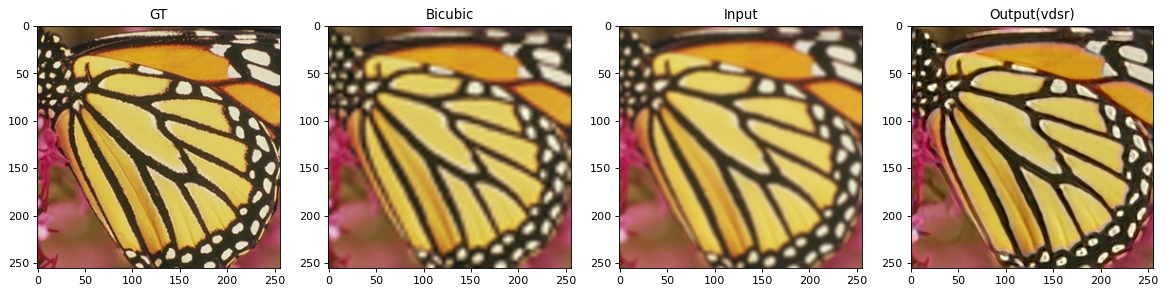

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F6758310940>,
 20.824648960041763,
 13.594359651769585)

In [192]:
display_PSNR(im_gt, im_b, im_b2, model)

# convert sample videos

In [122]:
folder = "/media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/"

infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel1-16.mp4"
superres_mp4(infile, outfile, model, factor=1.6,display=False,bitrate= "4000k")

  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel1-16.mp4
factor: 1.6 
width= 512 
height= 384 
bitrate= 4000k


100%|██████████| 900/900 [00:33<00:00, 26.94it/s]


True

In [123]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel1-10.mp4"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k")

  1%|          | 11/900 [00:00<00:08, 106.80it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel1-10.mp4
factor: 1.0 
width= 320 
height= 240 
bitrate= 4000k


100%|██████████| 900/900 [00:08<00:00, 109.72it/s]


True

In [124]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel1-20.mp4"
superres_mp4(infile, outfile, model, factor=2.0,display=False,bitrate= "4000k")

  0%|          | 3/900 [00:00<00:36, 24.58it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel1-20.mp4
factor: 2.0 
width= 640 
height= 480 
bitrate= 4000k


100%|██████████| 900/900 [00:38<00:00, 23.64it/s]


True

In [125]:
infile = "/media/SSD/superres/muffins30sec.mp4"
outfile = folder + "muffins30sechresperfuzmodel1-30.mp4"
superres_mp4(infile, outfile, model, factor=3.0,display=False,bitrate= "4000k")


  0%|          | 0/900 [00:00<?, ?it/s]

Original File: /media/SSD/superres/muffins30sec.mp4
frames= 900 
width= 320 
height= 240 
fps= 30.0

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/muffins30sechresperfuzmodel1-30.mp4
factor: 3.0 
width= 960 
height= 720 
bitrate= 4000k


100%|██████████| 900/900 [01:14<00:00, 12.16it/s]


True

In [126]:
dualfile= folder + "muffins30sechresperfuzmodel1-30dual.mp4"

In [127]:
# double scale for video x3 2 min
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -t 120 -filter_complex "[0:v] scale=iw*2:ih*2, pad=2*iw:ih [left]; [1:v] scale=iw/1.5:ih/1.5 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [128]:
# original scale , for video x3
#!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v] scale=iw*1:ih*1, pad=2*iw:ih [left]; [1:v] scale=iw/3:ih/3 [right]; [left][right] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [129]:
infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
outfile = folder + "super8hresperfuzmodel1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

  0%|          | 2/7195 [00:00<06:06, 19.64it/s]

Original File: /media/SSD/superres/super8/super8_best_from_mp2.mp4
frames= 7195 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8hresperfuzmodel1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 7195/7195 [04:34<00:00, 26.24it/s]


True

In [130]:

dualfile= folder + "super8hresperfuzmodel1dual.mp4"

In [131]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [132]:
# compare this model to the last one
infile = "/media/SSD/superres/Results/Superresolution train vdsr with perception loss multifuz/super8perfuzmodel1.mp4"
outfile = folder + "super8hresperfuzmodel1.mp4"
dualfile= folder + "super8hresperfuzmodel1-tolast-dual.mp4"

In [133]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [134]:
infile = "/media/SSD/superres/super8/Old 8mm Reels_1.mp4"
outfile = folder + "super8longhresperfuzmodel1.mp4"
error_file = "/media/SSD/superres/error.txt"
superres_mp4(infile, outfile, model, factor=1.0,display=False,bitrate= "4000k",errorfile = error_file)

Original File: /media/SSD/superres/super8/Old 8mm Reels_1.mp4
frames= 121409 
width= 720 
height= 480 
fps= 59.94005994005994

Process File: /media/SSD/superres/Results/Superresolution train vdsr with hres perception loss multifuz/super8longhresperfuzmodel1.mp4
factor: 1.0 
width= 720 
height= 480 
bitrate= 4000k


100%|██████████| 121409/121409 [1:15:25<00:00, 26.83it/s]


True

In [135]:
dualfile= folder + "super8longhresperfuzmodel1dual.mp4"

In [136]:
# original scale , for film x1, removed un needed scaling
!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/media/SSD/conda_env/superres --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, mov,mp4,m4a,3gp,3g2,mj2, from '/media/SSD/su

In [ ]:
def dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file):
    
    superres_mp4(infile, outfile, model, factor=factor,display=False,bitrate="4000k",errorfile = error_file)
    
    # original scale , for film x1, removed un needed scaling
    !ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}

In [ ]:
infile = folder + "super8percepmodel2.mp4"
outfile = folder + "super8percepmodel2x2.mp4"
dualfile= folder + "super8percepmodel2x2x1dual.mp4"
error_file = "/media/SSD/superres/error.txt"

dual_superres_mp4(infile, outfile, dualfile, model, factor=1.0,errorfile = error_file)

infile = "/media/SSD/superres/super8/super8_best_from_mp2.mp4"
dualfile= folder + "super8percepmodel2x2origdual.mp4"

!ffmpeg -i {'"'+infile+'"'} -i {'"'+outfile+'"'} -filter_complex "[0:v]  pad=2*iw:ih [left];  [left][1:v] overlay=main_w/2:0" -b:v 4000k {'"'+dualfile+'"'}